# Analysis of the Spaceship Titanic Dataset
This report seeks to analyze the fictional data from the Spaceship Titanic dataset (https://www.kaggle.com/competitions/spaceship-titanic/data), with the aim of preicting all the passengers who went missing on the spaceship voyage. In doing this, I run an exploratory data analysis, inferential analysis, and a range of different machine learning models. 

The following are all the variables we have present in our dataset:
1. **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
2. **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
3. **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
4. **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. **Destination** - The planet the passenger will be debarking to.
6. **Age** - The age of the passenger.
7. **VIP** - Whether the passenger has paid for special VIP service during the voyage.
8. **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. **Name** - The first and last names of the passenger.
10. **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# Hypotheses
It is difficult to build a hypothesis surrounding what led to people's disappearance on the spaceship. Indeed, since both the data and the whole scenario is fictional, there is not much to intuitively base a reason off of, nor anything that we can research off. As such, I do not form any hypotheses

### Relevant Libraries

In [ ]:
import json
from collections import Counter

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy.sparse
import seaborn as sns
import shap
import statsmodels.api as sm
from flask import Flask, jsonify, request
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy import stats
from scipy.stats import randint, uniform
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier

# Data Cleaning
Next, I gain a quick overview of the data, before I split the data into a training and a test set. So, I check for...
- *Duplicate rows*: There are none.
- *Null values*: Every column (with the exception of the 'Transported' column) is missing data.

In [2]:
file = pd.read_csv("train.csv", index_col=0)
file

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True


In [3]:
print("Duplicate rows:", file.duplicated().sum())

Duplicate rows: 0


In [4]:
print("NaN values per column:\n", file.isna().sum())

NaN values per column:
 HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


# Train-Test Split
First I split the data into a train and test split to ensure that there is no data leakage. I use a stratified split in case the data is skewed.

I then merge the columns of our training data to make the EDA and inferential model smoother.

In [5]:
X = file.drop("Transported", axis=1)
y = file["Transported"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

training_data = X_train.copy()
training_data["Transported"] = y_train

print("Training data shape:", training_data.shape)
training_data.head()

Training data shape: (6954, 13)


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
3868_04,Earth,False,G/630/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Harrie Braymon,True
1336_01,Earth,True,G/201/S,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
9193_01,Earth,NaN,G/1483/S,PSO J318.5-22,35.0,False,0.0,0.0,0.0,0.0,0.0,Camily Howence,False
5422_01,Europa,True,D/164/S,55 Cancri e,26.0,False,0.0,0.0,0.0,NaN,0.0,Pleion Sperap,True
5076_01,Earth,False,G/818/P,TRAPPIST-1e,13.0,False,0.0,0.0,60.0,1.0,5147.0,Alicey Wolferguson,False


# Exploratory Data Analysis

In [6]:
training_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6815.000000,6809.000000,6800.000000,6785.000000,6804.000000,6810.000000
mean,28.683786,230.149508,452.611176,170.033604,308.868460,296.649927
std,14.497439,676.338160,1602.465410,548.753286,1142.118125,1108.581827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,50.000000,65.500000,23.000000,55.000000,42.000000
max,79.000000,14327.000000,29813.000000,12253.000000,22408.000000,20336.000000


In [7]:
training_data.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

## Non-whole numbers in Age?
I was curious to see age being a float number, and so I looked into the spread of all non-whole numbers to understand whether there was anything anomalous going on. As seen below, it turns out that there actually are no float values. So for this reason, I go ahead and turn this column into an int(68) to double check that this is fine. An int value is also processed marginally faster than a float, and is also easier to interpret.

In [8]:
mask = training_data["Age"].notna() & ~training_data["Age"].apply(
    lambda x: float(x).is_integer()
)
non_whole_numbers = training_data[mask]
non_whole_numbers.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
training_data["Age"] = training_data["Age"].astype("Int64")
print(training_data["Age"].head())
print(training_data["Age"].dtype)

PassengerId
3868_04     0
1336_01    17
9193_01    35
5422_01    26
5076_01    13
Name: Age, dtype: Int64
Int64


In [10]:
age_series = training_data["Age"]
percent_under_1 = (age_series < 1).sum() / age_series.notna().sum() * 100
print(f"Percentage of people under 1: {percent_under_1:.2f}%")

Percentage of people under 1: 2.11%


## Splitting Cabin Information
The cabin column has a lot of interesting data components. To recall, it takes the shape of deck/num/side, where side can be either P for Port or S for Starboard. So I extract each component, and in the case of the binary value of which side the cabin is on (Port or Starboard), I create a Boolean column.

In [11]:
training_data[["CabinDeck", "CabinNum", "CabinSide"]] = training_data[
    "Cabin"
].str.split("/", expand=True)
training_data["IsStarboard"] = (training_data["CabinSide"] == "S").astype(int)
training_data["CabinNum"] = pd.to_numeric(
    training_data["CabinNum"], errors="coerce"
).astype("Int64")
training_data.drop("CabinSide", axis=1, inplace=True)
training_data.drop("Cabin", axis=1, inplace=True)

## Splitting PassengerID
Similar to the cabin column, the index itself has some potentially really interesting data. To recall, the ID takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
Consequently, I split this into two new columns.

In [12]:
training_data = training_data.reset_index()
training_data

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinDeck,CabinNum,IsStarboard
0,3868_04,Earth,False,TRAPPIST-1e,0,False,0.0,0.0,0.0,0.0,0.0,Harrie Braymon,True,G,630,1
1,1336_01,Earth,True,TRAPPIST-1e,17,False,0.0,0.0,0.0,0.0,0.0,NaN,True,G,201,1
2,9193_01,Earth,NaN,PSO J318.5-22,35,False,0.0,0.0,0.0,0.0,0.0,Camily Howence,False,G,1483,1
3,5422_01,Europa,True,55 Cancri e,26,False,0.0,0.0,0.0,NaN,0.0,Pleion Sperap,True,D,164,1
4,5076_01,Earth,False,TRAPPIST-1e,13,False,0.0,0.0,60.0,1.0,5147.0,Alicey Wolferguson,False,G,818,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,4362_01,Europa,False,TRAPPIST-1e,43,False,0.0,1947.0,0.0,0.0,1651.0,Altar Freednal,True,B,168,1
6950,4678_01,Earth,False,TRAPPIST-1e,38,False,183.0,203.0,0.0,110.0,374.0,Sonnie Mcleaney,False,F,951,0
6951,7579_01,Earth,False,PSO J318.5-22,45,False,1.0,7.0,56.0,613.0,0.0,Willy Curton,True,G,1229,1
6952,0460_01,Earth,True,PSO J318.5-22,24,False,0.0,0.0,0.0,0.0,0.0,Shawne Jenningley,True,G,65,1


In [13]:
training_data[["GroupID", "PassengerNumber"]] = training_data["PassengerId"].str.split(
    "_", expand=True
)
training_data["GroupID"] = pd.to_numeric(
    training_data["GroupID"], errors="coerce"
).astype("Int64")
training_data["PassengerNumber"] = pd.to_numeric(
    training_data["PassengerNumber"], errors="coerce"
).astype("Int64")
training_data.drop("PassengerId", axis=1, inplace=True)

## Splitting Name into Key figures
As can be seen below, the column of 'Name' is not something that contributes a meaningful degree of accuracy to the model. Almost everyone has a completely unique name, and so one-hot-encoding this would most likely just add a lot of noise.
Alternatively, one could also perhaps use a bag-of-words model to try to extract all the key letters in the name, to see if there is some unique constellation. However, as our data model is relatively small, I believe this would more so overfit our model.
We can, however, extract different data from this model, such as the length of the name.

In [14]:
unique_name_counts = training_data["Name"].value_counts()
num_unique_names = (unique_name_counts == 1).sum()
print(f"Number of people with a completely unique name: {num_unique_names}")

Number of people with a completely unique name: 6771


In [15]:
training_data["NameLength"] = training_data["Name"].str.len()
training_data.drop("Name", axis=1, inplace=True)

## Distributions of Variables
As can be seen, there are a few groups which are very low in number, such as for the proportion of:
- VIP members
- Cryo-sleep members
- Destinations
- Room Service

Moreover, it seems that almost every single continuous variable has a very long tail, which could also constitute a problem.

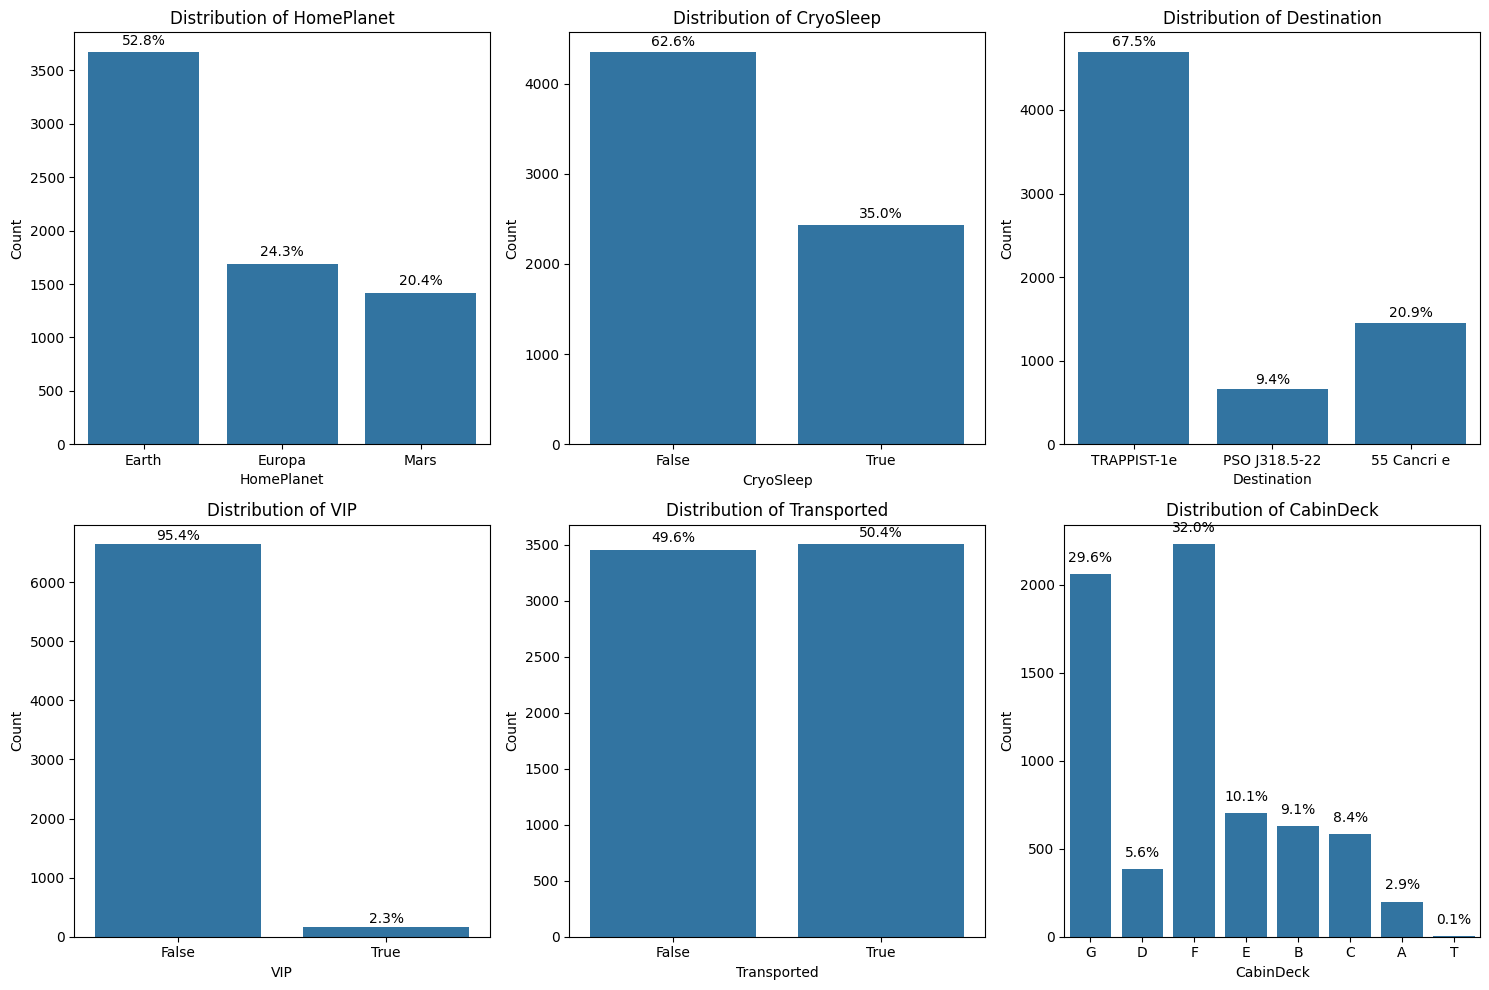

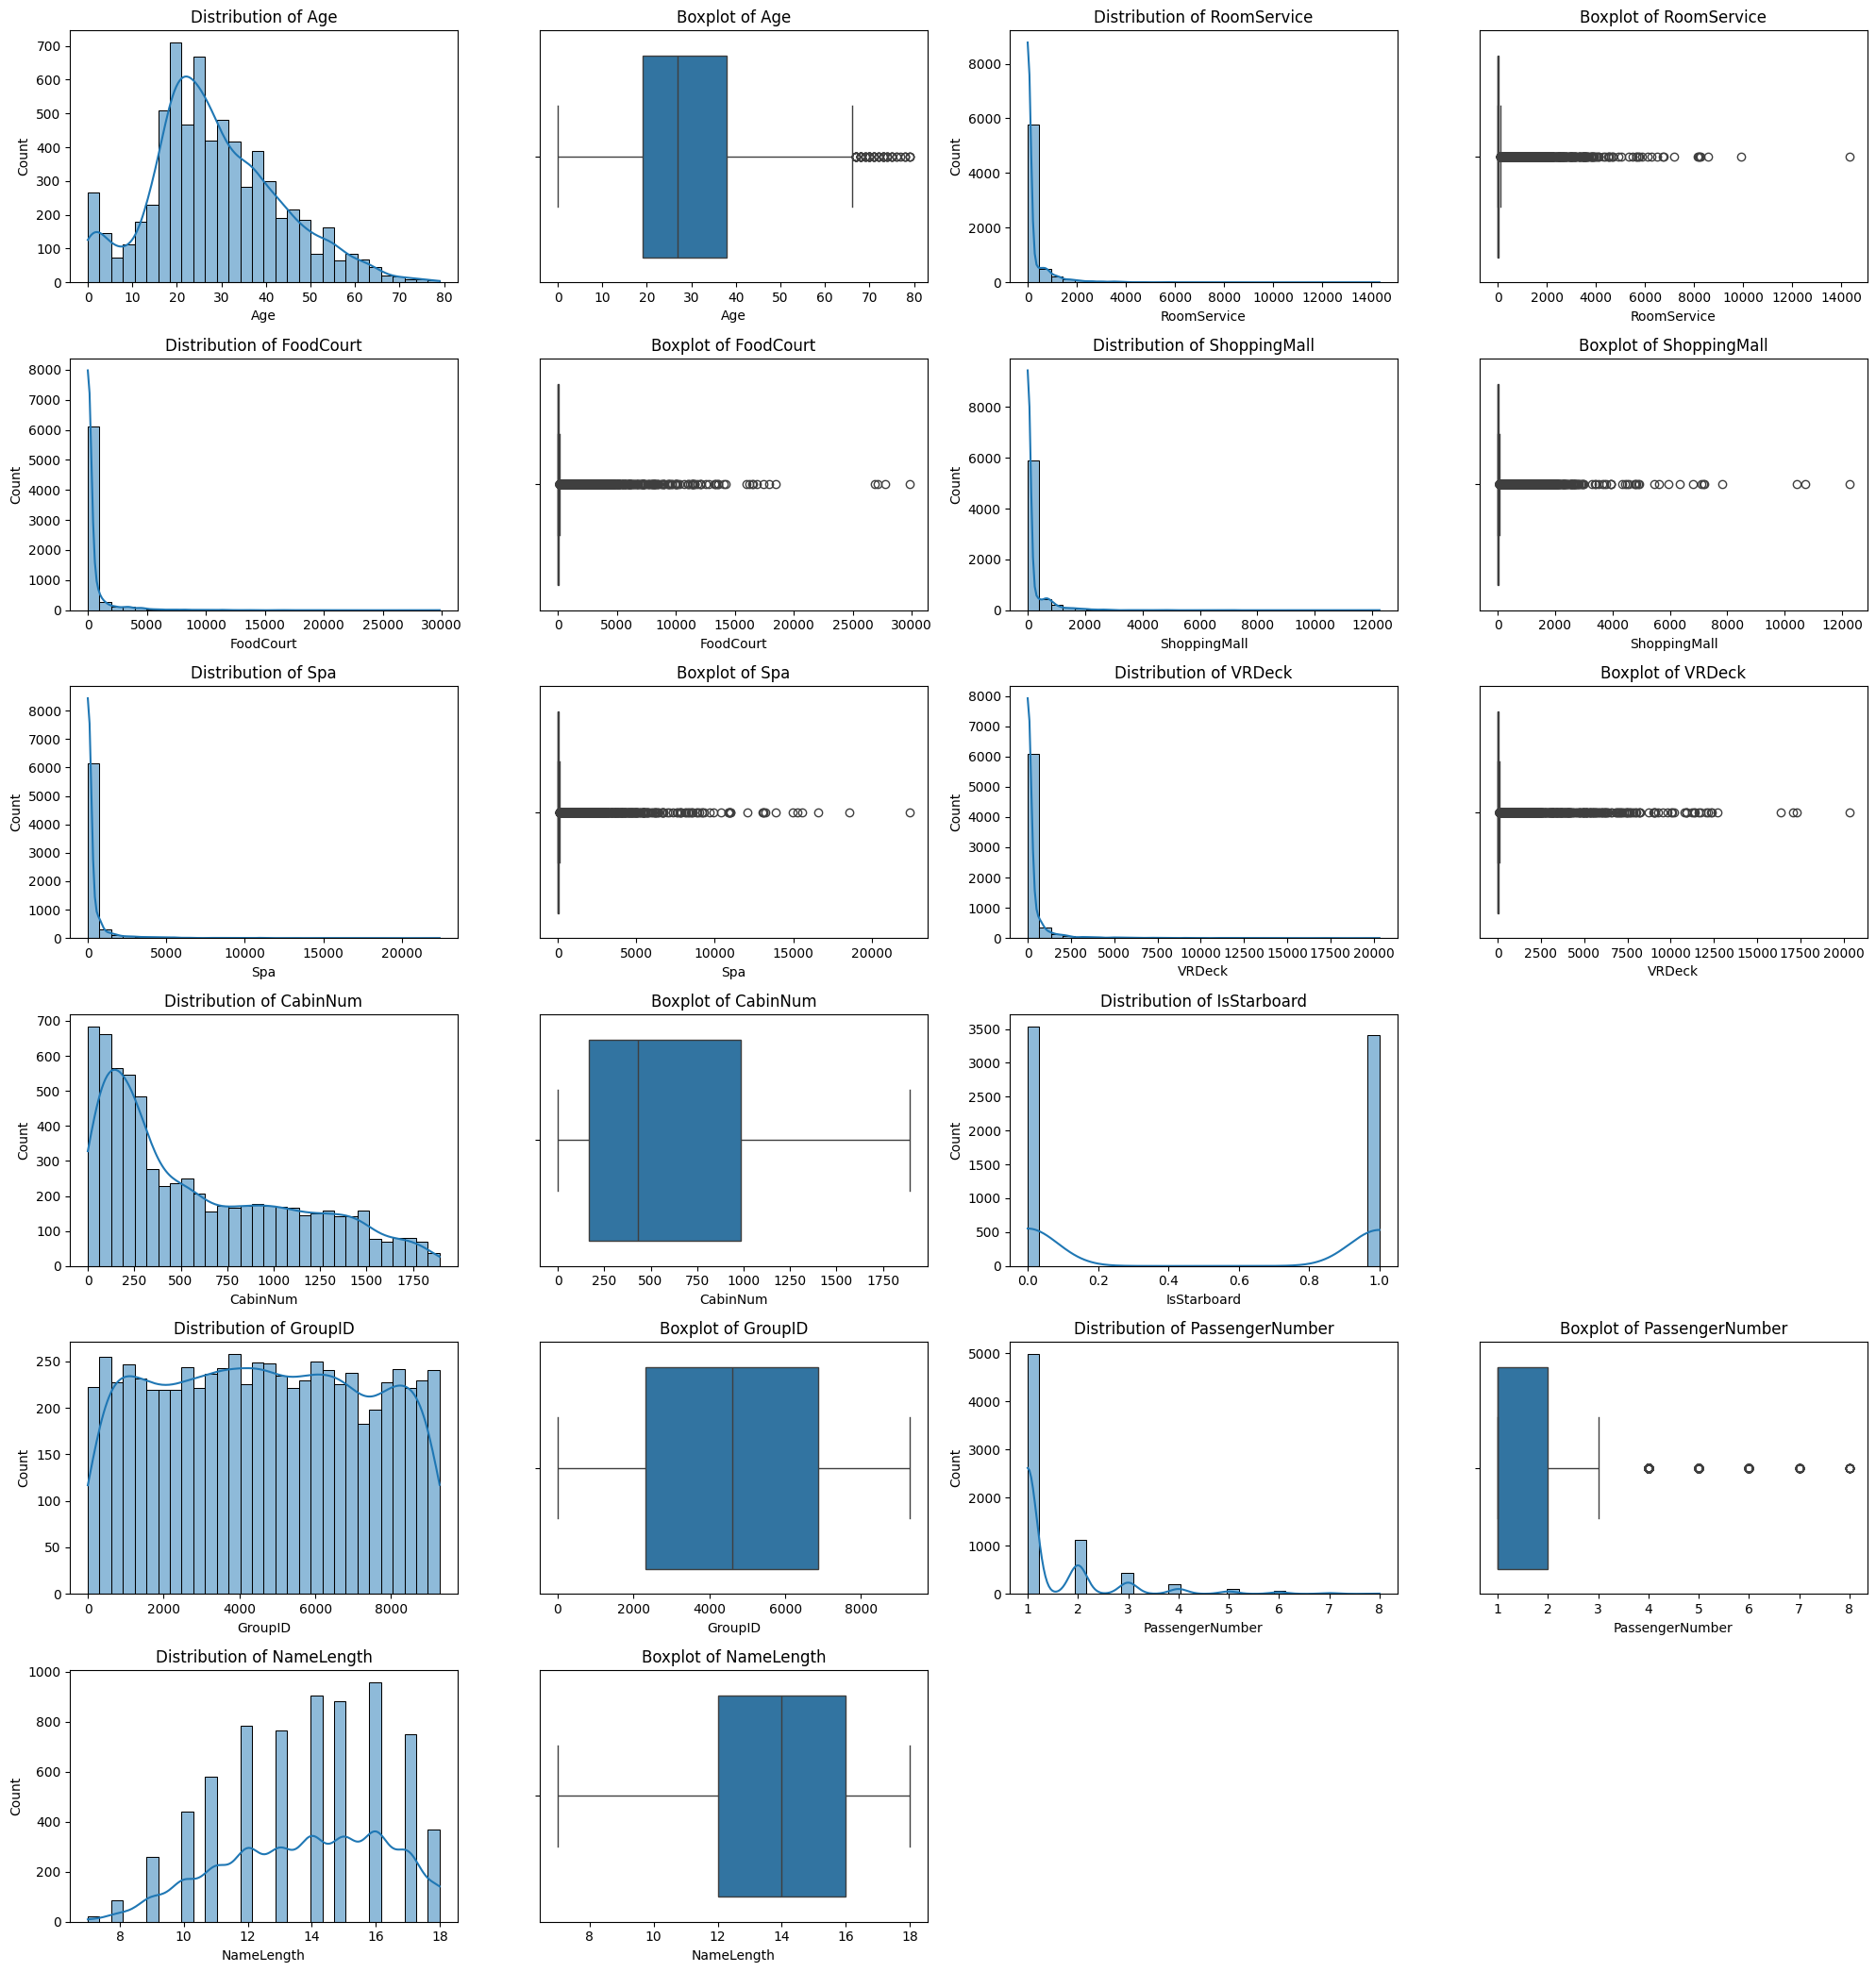

In [16]:
columns_to_exclude = ["Cabin", "Name"]
columns_to_plot = [
    col
    for col in training_data.select_dtypes(
        include=["object", "category", "bool"]
    ).columns
    if training_data[col].nunique() <= 20 and col not in columns_to_exclude
]

plt.figure(figsize=(15, 5 * ((len(columns_to_plot) + 2) // 3)))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot((len(columns_to_plot) + 2) // 3, 3, i)

    sns.countplot(x=col, data=training_data)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    total = len(training_data)
    for p in plt.gca().patches:
        height = p.get_height()
        plt.gca().text(
            p.get_x() + p.get_width() / 2.0,
            height + 0.01 * total,
            f"{height/total:.1%}",
            ha="center",
        )

plt.tight_layout()
plt.show()

features = training_data.select_dtypes(include=["int64", "float64"]).columns.tolist()

features = [col for col in features if col not in ["CustomerID", "ID"]]

n_cols = 4
n_rows = int(len(features) * 2 / n_cols) + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3.5))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(training_data[col], kde=True, bins=30, ax=axes[2 * i])
    axes[2 * i].set_title(f"Distribution of {col}")

    if training_data[col].nunique() > 2:
        sns.boxplot(x=training_data[col], ax=axes[2 * i + 1])
        axes[2 * i + 1].set_title(f"Boxplot of {col}")
    else:
        axes[2 * i + 1].remove()

for j in range(2 * len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

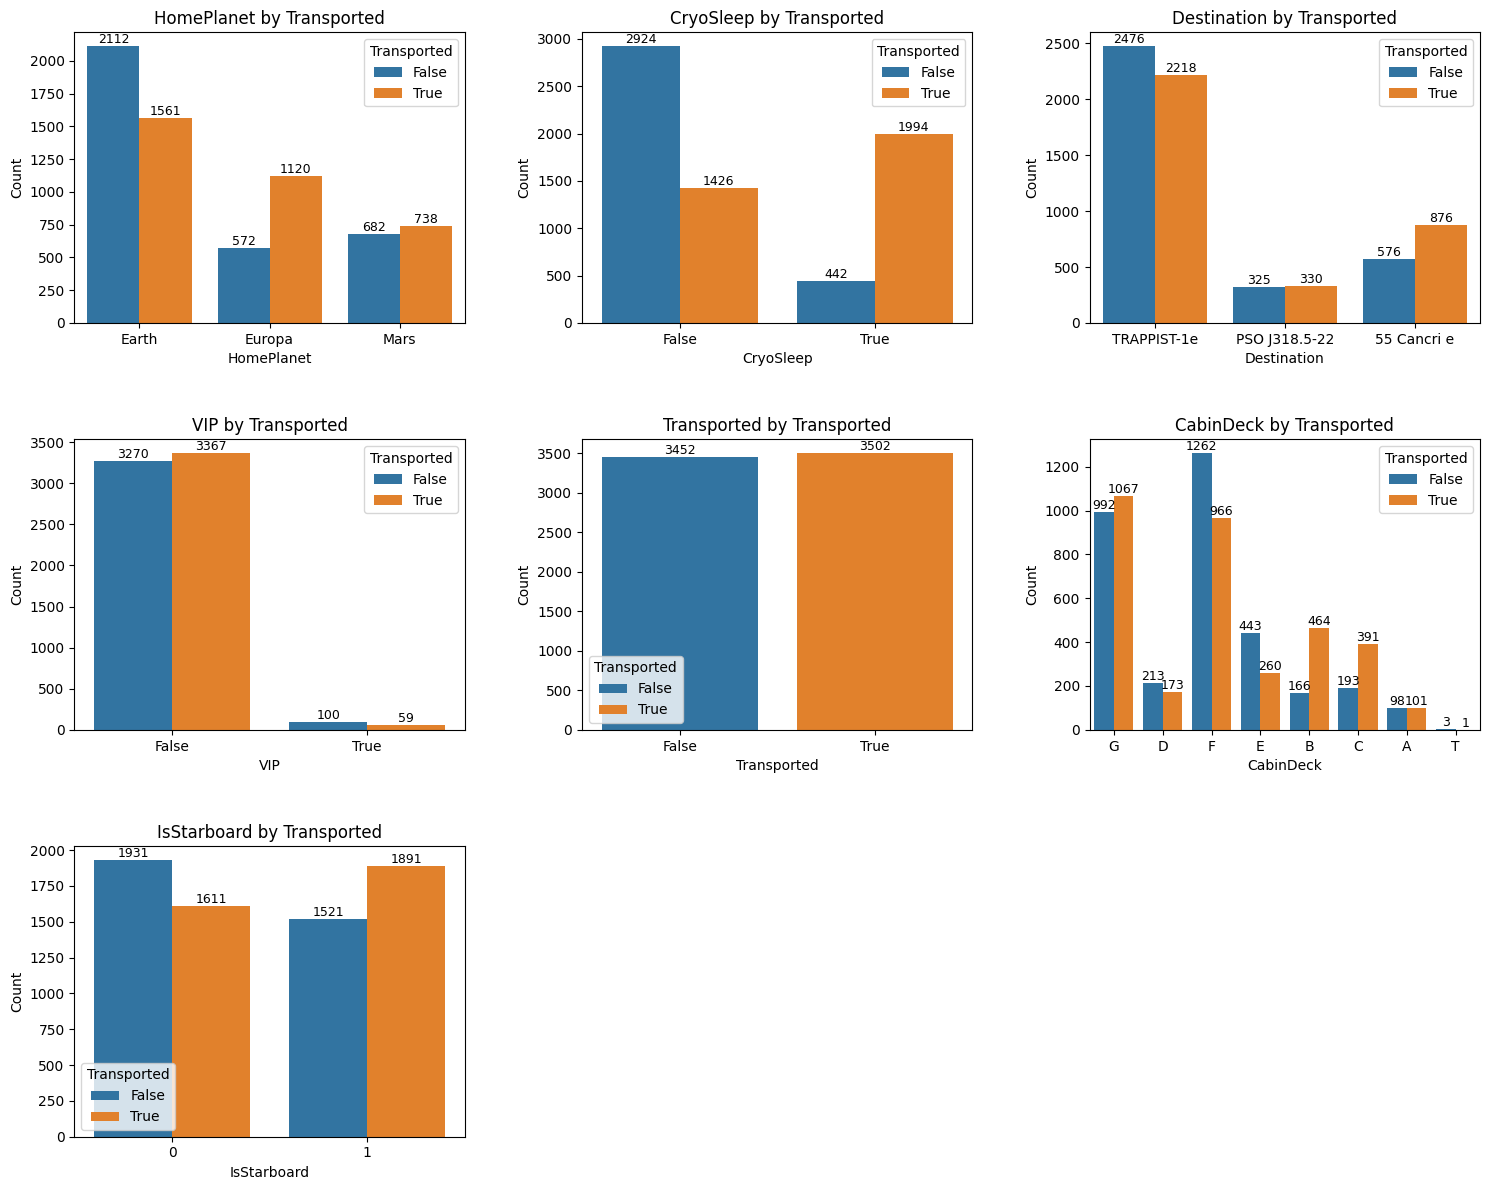

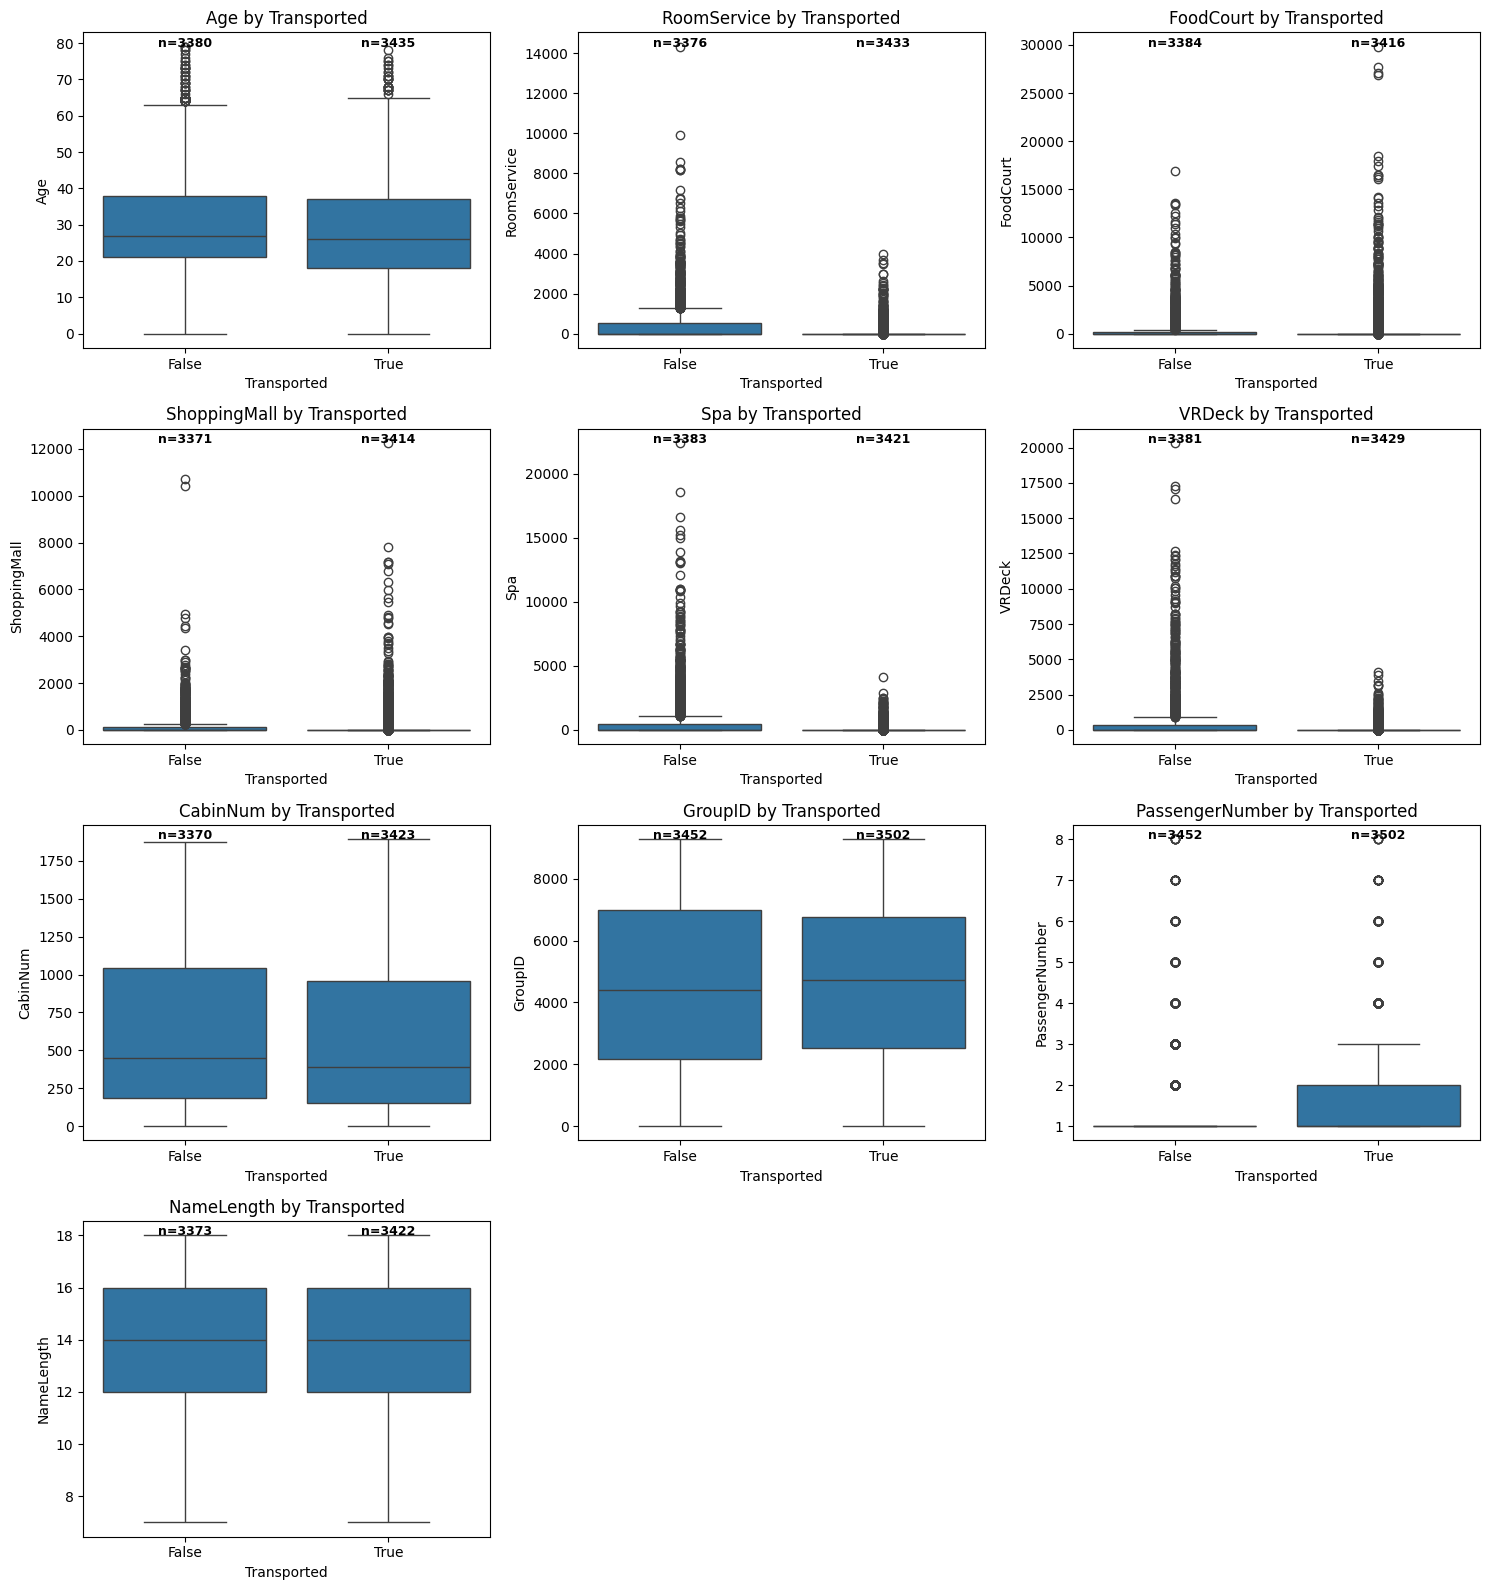

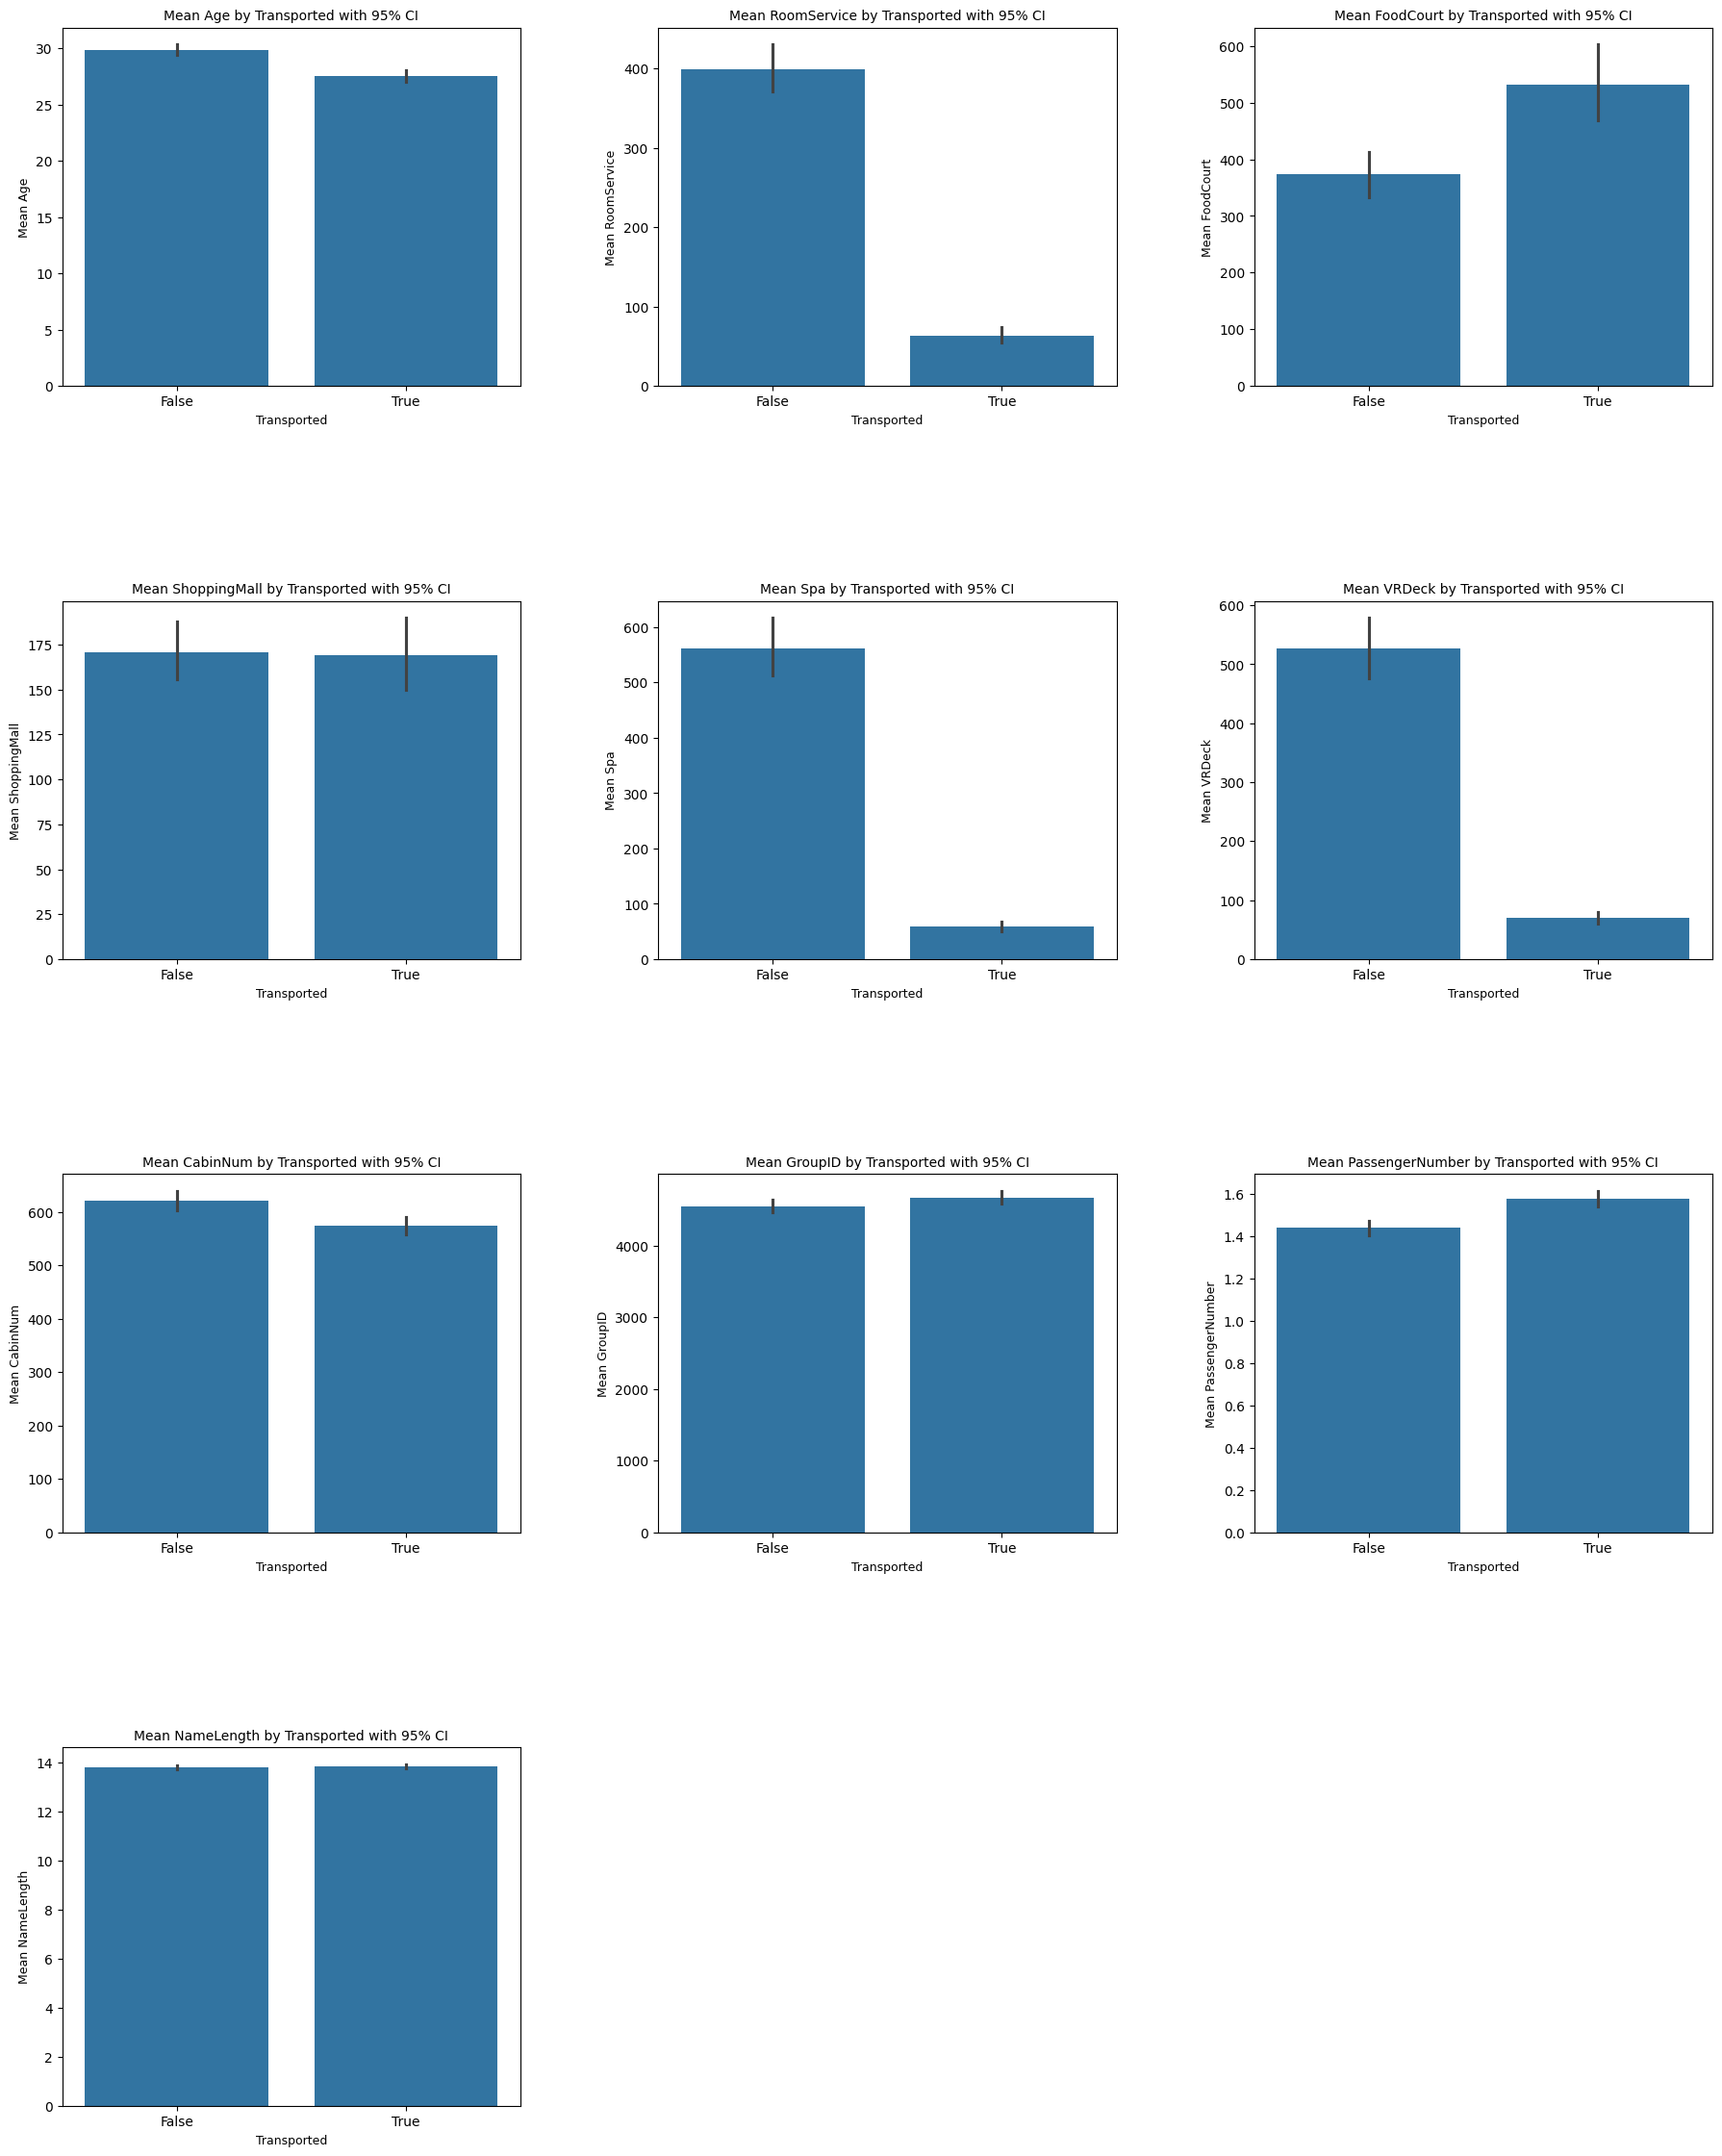

In [17]:
columns_to_exclude = ["Cabin", "Name"]

cat_columns = [
    col
    for col in training_data.select_dtypes(
        include=["object", "category", "bool"]
    ).columns
    if col not in columns_to_exclude
    and training_data[col].nunique() <= 20  # <-- exclude here
]

num_columns = [
    col
    for col in training_data.select_dtypes(include=["int64", "float64"]).columns
    if col not in columns_to_exclude
]

binary_cols = [col for col in num_columns if training_data[col].nunique() == 2]

combined_columns = [
    col for col in (cat_columns + binary_cols) if col not in columns_to_exclude
]

n_cols = 3
n_rows = (len(combined_columns) // n_cols) + int(len(combined_columns) % n_cols != 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(combined_columns):
    ax = axes[i]
    sns.countplot(x=col, hue="Transported", data=training_data, ax=ax)
    ax.set_title(f"{col} by Transported")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f"{int(height)}",
                (p.get_x() + p.get_width() / 2, height),
                ha="center",
                va="bottom",
                fontsize=9,
                color="black",
            )

for j in range(len(combined_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

continuous_cols = [col for col in num_columns if training_data[col].nunique() > 2]

n_cols = 3
n_rows = (len(continuous_cols) // n_cols) + int(len(continuous_cols) % n_cols != 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    ax = axes[i]
    sns.boxplot(x="Transported", y=col, data=training_data, ax=ax)
    ax.set_title(f"{col} by Transported")
    ax.set_xlabel("Transported")
    ax.set_ylabel(col)
    counts = training_data.groupby("Transported")[col].count()
    for stroke_val, count in counts.items():
        ax.text(
            stroke_val,
            training_data[col].max(),
            f"n={count}",
            horizontalalignment="center",
            color="black",
            fontsize=9,
            weight="bold",
        )

for j in range(len(continuous_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

n_cols = 3
n_rows = (len(continuous_cols) // n_cols) + int(len(continuous_cols) % n_cols != 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    ax = axes[i]
    sns.barplot(x="Transported", y=col, data=training_data, errorbar=("ci", 95), ax=ax)
    ax.set_title(f"Mean {col} by Transported with 95% CI", fontsize=10)
    ax.set_xlabel("Transported", fontsize=9)
    ax.set_ylabel(f"Mean {col}", fontsize=9)

for j in range(len(continuous_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.6, wspace=0.3)
plt.show()

## One-Hot-Encoding and Data Imputation for Missing Values
Next I check for multicollinearity. To do that, I must first one-hot encode all the variables that are not numeric. I only do this for columns that have less than ten options, as I do not want a one-hot-encoded of every column in the spaceship.

I also use data imputation to fill the NaN values from the 'bmi' column, as earlier identified. 

In [18]:
non_numeric_cols = [
    col
    for col in training_data.select_dtypes(exclude=["number"]).columns
    if 3 <= training_data[col].nunique() <= 10
]

encoded_training_data = pd.get_dummies(
    training_data, columns=non_numeric_cols, drop_first=True
)

bool_cols = encoded_training_data.select_dtypes(include=["bool"]).columns
encoded_training_data[bool_cols] = encoded_training_data[bool_cols].astype(int)

imputer = KNNImputer(n_neighbors=5)
numeric_cols = encoded_training_data.select_dtypes(include=["number"]).columns
encoded_training_data[numeric_cols] = imputer.fit_transform(
    encoded_training_data[numeric_cols]
)

encoded_training_data.columns = [
    col.replace(" ", "_").replace("-", "_") for col in encoded_training_data.columns
]

encoded_training_data = encoded_training_data.dropna()

In [19]:
encoded_training_data.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'CabinNum', 'IsStarboard', 'GroupID',
       'PassengerNumber', 'NameLength', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_PSO_J318.5_22', 'Destination_TRAPPIST_1e', 'CabinDeck_B',
       'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F',
       'CabinDeck_G', 'CabinDeck_T'],
      dtype='object')

In [20]:
encoded_training_data = encoded_training_data.dropna()

In [21]:
bool_like_cols = [
    col
    for col in encoded_training_data.columns
    if set(encoded_training_data[col].dropna().unique()) <= {True, False}
]

for col in bool_like_cols:
    encoded_training_data[col] = encoded_training_data[col].astype("bool").astype(int)

## Standardizing the Data
Next I standardize the data using RobustSclaer so that it can better be studied in an inferential logistic regression, by lessening the influence of outliers and wide distributions in continuous variables.

In [22]:
num_columns = [
    col
    for col in training_data.select_dtypes(include=["int64", "float64"]).columns
    if col not in columns_to_exclude
]

scaler = RobustScaler()

encoded_training_data[num_columns] = scaler.fit_transform(
    encoded_training_data[num_columns]
)

## Checking for Multicollinearity
I create a heat map to see if any different variables are highly correlated. As can be seen, there are a few variables which seem noticeably correlated. 

However, a VIF test shows this to not be strongly of note (i.e., VIF > 10). However, there are three scores which are between 5 and 9, which are potentially borderline. However, as I know that these are distinct columns, I decide to proceed.

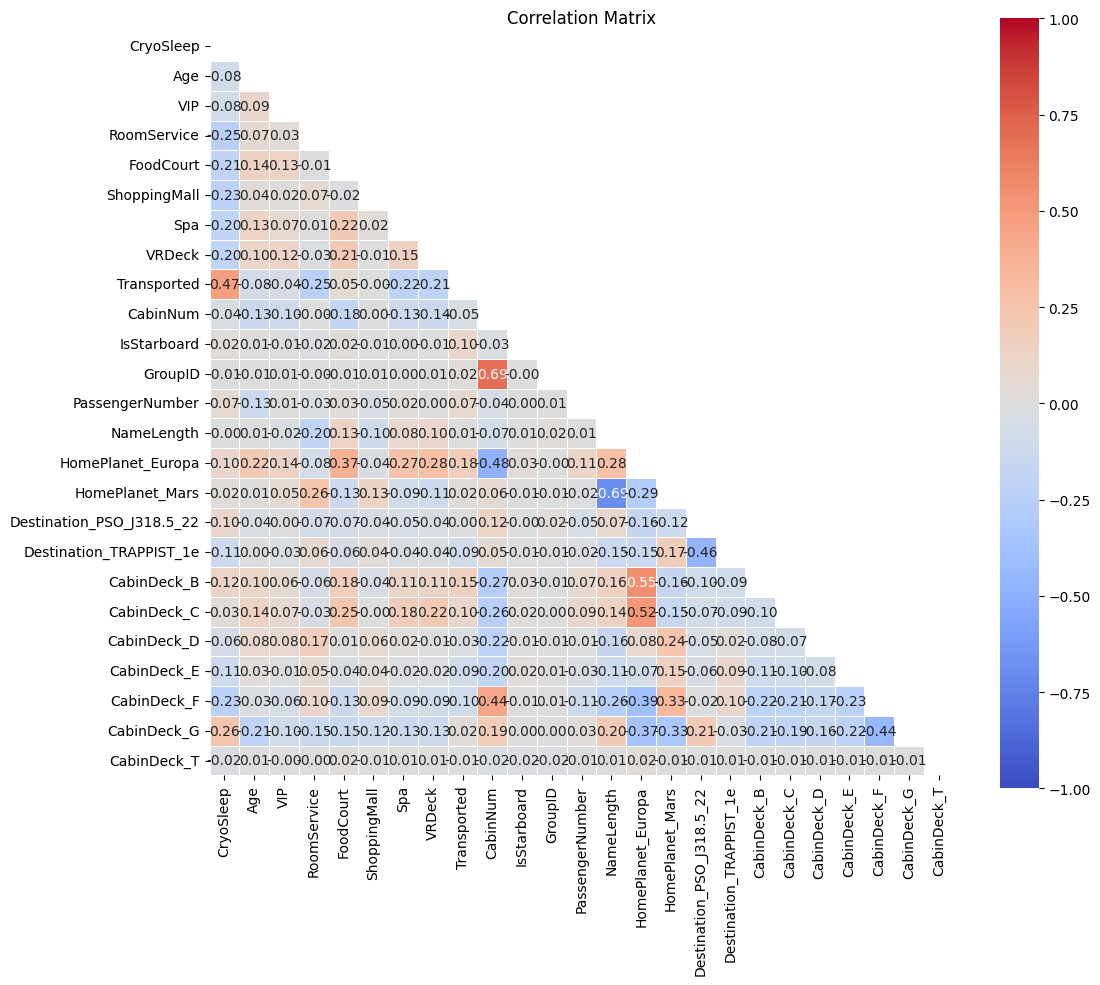

In [23]:
corr = encoded_training_data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Matrix")
plt.show()

In [24]:
encoded_training_data.dtypes

CryoSleep                      int64
Age                          float64
VIP                            int64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                    int64
CabinNum                     float64
IsStarboard                  float64
GroupID                      float64
PassengerNumber              float64
NameLength                   float64
HomePlanet_Europa              int64
HomePlanet_Mars                int64
Destination_PSO_J318.5_22      int64
Destination_TRAPPIST_1e        int64
CabinDeck_B                    int64
CabinDeck_C                    int64
CabinDeck_D                    int64
CabinDeck_E                    int64
CabinDeck_F                    int64
CabinDeck_G                    int64
CabinDeck_T                    int64
dtype: object

In [25]:
X = encoded_training_data.drop("Transported", axis=1)

X_with_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(X_with_const.shape[1])
]

print(vif_data)

                     Variable        VIF
0                       const  38.469247
1                   CryoSleep   1.666421
2                         Age   1.118650
3                         VIP   1.067960
4                 RoomService   1.183529
5                   FoodCourt   1.291019
6                ShoppingMall   1.092812
7                         Spa   1.156999
8                      VRDeck   1.183462
9                    CabinNum   6.794224
10                IsStarboard   1.016668
11                    GroupID   4.150959
12            PassengerNumber   1.058000
13                 NameLength   1.948367
14          HomePlanet_Europa   5.715813
15            HomePlanet_Mars   2.596062
16  Destination_PSO_J318.5_22   1.418333
17    Destination_TRAPPIST_1e   1.387355
18                CabinDeck_B   2.762181
19                CabinDeck_C   2.606359
20                CabinDeck_D   2.235487
21                CabinDeck_E   3.431190
22                CabinDeck_F   9.314738
23              

## Last Cleaning for Running Logistic Regression

In [26]:
encoded_training_data.columns = [
    col.replace(" ", "_").replace("-", "_").replace(".", "_")
    for col in encoded_training_data.columns
]

# Running a Logistic Regression to Investigate Coefficients
Next I run a logistic regression to build an inferential model and further understand the validity of each coefficient in later building a predictive model.

In [27]:
target = "Transported"
predictors = encoded_training_data.columns.drop(target)

formula = f"{target} ~ {' + '.join(predictors)}"

model = logit(formula, data=encoded_training_data).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.433721
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Transported   No. Observations:                 6634
Model:                          Logit   Df Residuals:                     6609
Method:                           MLE   Df Model:                           24
Date:                Mon, 30 Jun 2025   Pseudo R-squ.:                  0.3742
Time:                        15:12:02   Log-Likelihood:                -2877.3
converged:                       True   LL-Null:                       -4598.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.3901      0.212     -1.843      0.065      -0.

Based on the regression output, several predictors appear to be statistically significant in explaining the likelihood of being transported (i.e., p < 0.05). These include:

- CryoSleep (p < 0.001)
- Age (p < 0.001)
- RoomService (p < 0.001)
- FoodCourt (p < 0.001)
- ShoppingMall (p < 0.001)
- Spa (p < 0.001)
- VRDeck (p < 0.001)
- IsStarboard (p < 0.001)
- HomePlanet_Europa (p < 0.001)
- HomePlanet_Mars (p < 0.001)
- Destination_PSO_J318_5_22 (p < 0.001)
- Destination_TRAPPIST_1e (p < 0.001)
- CabinDeck_B (p < 0.001)
- CabinDeck_C (p < 0.001)

The remaining predictors — including VIP, CabinNum, GroupID, PassengerNumber, and the rest of the cabin deck dummy variables — are not statistically significant at the 0.05 level.

As such, I reran the model including only the significant predictors to refine the coefficient estimates and improve model interpretability.

In [28]:
significant_vars = [
    "CryoSleep",
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "IsStarboard",
    "HomePlanet_Europa",
    "HomePlanet_Mars",
    "Destination_PSO_J318_5_22",
    "Destination_TRAPPIST_1e",
    "CabinDeck_B",
    "CabinDeck_C",
]

formula = f"{target} ~ {' + '.join(significant_vars)}"

model = logit(formula, data=encoded_training_data).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.437977
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Transported   No. Observations:                 6634
Model:                          Logit   Df Residuals:                     6619
Method:                           MLE   Df Model:                           14
Date:                Mon, 30 Jun 2025   Pseudo R-squ.:                  0.3681
Time:                        15:12:03   Log-Likelihood:                -2905.5
converged:                       True   LL-Null:                       -4598.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.2748      0.097     -2.821      0.005      -0.

The logistic regression model was statistically significant overall, as indicated by a Likelihood Ratio Test p-value < 0.001. This suggests that the set of predictors included in the model collectively contribute to explaining whether a passenger was transported. Moreover, McFadden's Pseudo R² of 0.3723 indicates that approximately 37.2% of the variance in the dependent variable. This is a strong result

Below are the calibrated variables 
1. **CryoSleep (β = 1.3269, p < 0.001)**. Passengers in cryosleep had significantly higher odds of being transported. Specifically, being in cryosleep increases the log odds of transport by 1.3269.
2. **Age (β = -0.1549, p < 0.001)**. With each unit increase in age, the log odds of being transported decrease by 0.1549. This means younger passengers were more likely to be transported.
3. **RoomService (β = -0.0797, p < 0.001)**. Higher spending on room service is associated with lower odds of being transported. For each scaled unit increase in room service expenses, the log odds of transport decrease by 0.0797.
4. **FoodCourt (β = 0.0387, p < 0.001)**. Increased spending at the food court slightly increases the likelihood of being transported, raising the log odds by 0.0387 per unit.
5. **ShoppingMall (β = 0.0180, p < 0.001)**. More spending at the shopping mall is linked with higher odds of transport. Each unit increase raises the log odds by 0.0180.
6. **Spa (β = -0.1255, p < 0.001)**. More spa usage correlates with lower odds of transport. Every unit increase in spa spending reduces the log odds by 0.1255.
7. **VRDeck (β = -0.0989, p < 0.001)**. Spending on the VR deck is negatively associated with being transported, with the log odds decreasing by 0.0989 per unit increase.
8. **IsStarboard (β = 0.5565, p < 0.001)**. Being located on the starboard side increases the odds of being transported. The log odds increase by 0.5565 for passengers on that side.
9. **HomePlanet_Europa (β = 1.3639, p < 0.001)**. Passengers from Europa were much more likely to be transported. The log odds increase by 1.3639 relative to the reference group.
10. **HomePlanet_Mars (β = 0.6565, p < 0.001)**. Coming from Mars also increased the odds of being transported, with a log odds increase of 0.6565.
11. **Destination_PSO_J318_5_22 (β = -0.4434, p < 0.001)**. Traveling to this destination decreased the likelihood of being transported, reducing the log odds by 0.4434.
12. **Destination_TRAPPIST_1e (β = -0.4704, p < 0.001)**. Similarly, heading to TRAPPIST-1e decreased the odds of transport, lowering the log odds by 0.4704.
13. **CabinDeck_B (β = 0.9515, p < 0.001)**. Being on deck B increases the likelihood of transport, with log odds higher by 0.9515 compared to the reference deck.
14. **CabinDeck_C (β = 2.0574, p < 0.001)**. Deck C passengers were much more likely to be transported, with an increase in log odds of 2.0574.

In conclusion, it seems as though the five strongest predictors are:
1. **CabinDeck_C**. β = 2.0574
2. **HomePlanet_Europa**. β = 1.3639	
3. **CryoSleep**. β = 1.3269
4. **CabinDeck_B**. β = 0.9515	
5. **HomePlanet_Mars**. β = 0.6565	

# Assumptions of the Model
Next I quickly check the assumptions of the model to ensure that these results warrant trust

## Multicollinearity
As the VIF score showed earlier, none of the variables were significantly correlated with one another - thus upholding this assumption.

## Adequately Large Sample Size
As discussed earlier, there are several groups that are quite low in sample size. However, to preserve the already small number of cases in the minority, I do not drop them, and I do not use techniques like SMOTE, as they cannot apply to the minority cases.
However, the issue of them being present in the dataset is not really material, as they do not constitute significant variables, and are cut in the calibrated model to reduce noise anyway.

## No Outliers
As seen earlier in the boxplot, there were outliers. However, I decided to keep these in the model, given the low amount of cases we have in the minority case already. To treat this instead, I used RobustScaler, which is adept at treating outliers.

## Independent Observations
From our perspective, we can assume the independence of observations, as they ostensibly would be so. However, as we are not familiar with how the data was sampled, we cannot speak too confidently to this point.

# Building and Comparing Different ML Models
Next, I seek to build predictive modesl that can reliably predict whether someone was transported to an alternate reality. In doing this, I first build a pipeline to...
1. One-Hot-encode all columns except for columns with more than 10 options
2. Change boolean values to 0 and 1, for those that weren't already (i.e., were 'False' and 'True').
3. Split the PassengerID information.
4. Splitting Cabin Info.
5. Drop columns with more than 10 options in them (as these refer to the 'Cabin' and PassengerID' Columns). These no longer have meaning, as we have dissected them for their data.
6. Use data imputation with KNN for missing values.
7. Use data imputation with SimpleImputer for missing values, replacing them as constant 'missing' values, in order to perhaps spot patterns in the missing data.
8. Use RobustScaler for all continuous variables to get around the outliers.
9. Cut off remaining long tails to prevent this skewing data (i.e., cut off data points that are outside the 99th percentile).
10. Clean the column names so as to have any periods or spaces.

Since the only metric that the Kaggle competition concerns itself with is accuracy, this is also the only thing that I will be focusing on. Regardless, I will also be running a range of other evaluation metrics to more closely inspect the data.

In [29]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# === Custom Transformers ===

class ColumnDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_to_drop_ = []
        total_rows = len(X)
        for col in X.columns:
            missing_pct = X[col].isna().sum() / total_rows * 100
            is_numeric = pd.api.types.is_numeric_dtype(X[col])
            unique_vals = X[col].dropna().unique()
            is_binary = set(unique_vals).issubset({0, 1}) and len(unique_vals) <= 2
            if missing_pct >= 50:
                self.columns_to_drop_.append(col)
            elif (not is_numeric or is_binary) and missing_pct > 30:
                self.columns_to_drop_.append(col)
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop_, errors="ignore")


class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.025, 0.025)):
        self.limits = limits

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        for col in X_.select_dtypes(include=[np.number]).columns:
            if X_[col].nunique() > 2:
                X_[col] = winsorize(X_[col], limits=self.limits)
        return X_


class TailClipper(BaseEstimator, TransformerMixin):
    def __init__(self, clip_percentile=0.99):
        self.clip_percentile = clip_percentile
        self.percentiles_ = {}

    def fit(self, X, y=None):
        for col in X.columns:
            self.percentiles_[col] = X[col].quantile(self.clip_percentile)
        return self

    def transform(self, X):
        X_ = X.copy()
        for col, p in self.percentiles_.items():
            X_[col] = np.clip(X_[col], a_min=None, a_max=p)
        return X_


class VIFDropper(BaseEstimator, TransformerMixin):
    def __init__(self, vif_threshold=4):
        self.vif_threshold = vif_threshold
        self.columns_to_keep_ = []

    def fit(self, X, y=None):
        X_ = X.copy()
        dropped = []
        while True:
            X_const = add_constant(X_)
            vifs = pd.Series(
                [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])],
                index=X_const.columns
            ).drop("const", errors="ignore")

            if vifs.empty or vifs.max() <= self.vif_threshold:
                break
            to_drop = vifs.idxmax()
            dropped.append(to_drop)
            X_ = X_.drop(columns=[to_drop])

        self.columns_to_keep_ = X_.columns.tolist()
        return self

    def transform(self, X):
        return X[self.columns_to_keep_]


# === Build Pipeline Function ===

def build_pipeline(X):
    # Determine column types
    binary_cols = [col for col in X.columns if X[col].nunique(dropna=True) == 2]
    categorical_cols = [
        col for col in X.select_dtypes(include=["object", "category"]).columns
        if 2 < X[col].nunique() <= 10
    ]
    continuous_cols = [
        col for col in X.select_dtypes(include=["float64", "int64"]).columns
        if col not in binary_cols
    ]

    # Pipelines
    cont_pipeline = Pipeline([
        ("imputer", KNNImputer(n_neighbors=3)),
        ("scaler", RobustScaler()),
        ("winsor", Winsorizer()),
        ("clip", TailClipper(clip_percentile=0.99))
    ])

    cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
    ])

    bin_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])

    preprocessor = ColumnTransformer([
        ("cont", cont_pipeline, continuous_cols),
        ("cat", cat_pipeline, categorical_cols),
        ("bin", bin_pipeline, binary_cols),
    ])

    # Final pipeline
    full_pipeline = Pipeline([
        ("drop_missing", ColumnDropper()),
        ("preprocessor", preprocessor),
        ("vif", VIFDropper(vif_threshold=4))
    ])

    return full_pipeline, continuous_cols, categorical_cols, binary_cols


# === Usage Example ===

# Example:
# X = final_table.drop("TARGET", axis=1)
# y = final_table["TARGET"]
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.1, stratify=y, random_state=42
# )
#
# pipeline, cont_cols, cat_cols, bin_cols = build_pipeline(X_train)
# pipeline.fit(X_train)
# X_train_transformed = pipeline.transform(X_train)
# X_test_transformed = pipeline.transform(X_test)

# At this point, you can train any model on X_train_transformed / y_train


### Creating Functions for Models
Below I create a few functions which are important for the ML models. This just helps clean up repetitive code.

In [30]:
def evaluate_model_performance(y_test, y_pred, y_proba, class_labels=None):
    """
    Prints evaluation metrics and plots confusion matrix and ROC curve.

    Parameters:
        y_test (array-like): True labels.
        y_pred (array-like): Predicted class labels.
        y_proba (array-like): Predicted probabilities for the positive class.
        class_labels (list): Labels for confusion matrix axes.
    """
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"\nTest AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

    class_labels = list(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


def plot_learning_curve(
    model, X, y, scoring="average_precision", cv=5, title="Learning Curve"
):
    """
    Plots a learning curve showing training and validation scores.

    Parameters:
        model: Fitted estimator or pipeline.
        X (array-like): Feature matrix.
        y (array-like): Target labels.
        scoring (str): Scoring metric to evaluate (default: "average_precision").
        cv (int or cross-validation generator): Number of CV folds or CV strategy.
        title (str): Title for the plot.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, "o-", color="blue", label="Training score")
    plt.fill_between(
        train_sizes,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1,
        color="blue",
    )

    plt.plot(train_sizes, val_mean, "o-", color="green", label="Validation score")
    plt.fill_between(
        train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green"
    )

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{scoring.replace('_', ' ').title()} Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def get_feature_names(preprocessor, cont_cols, cat_cols, bin_cols):
    """
    Combines continuous, binary, and one-hot encoded categorical feature names
    from a fitted ColumnTransformer.

    Parameters:
        preprocessor (ColumnTransformer): The fitted ColumnTransformer.
        cont_cols (list): List of continuous column names.
        cat_cols (list): List of categorical column names.
        bin_cols (list): List of binary column names.

    Returns:
        np.ndarray: All feature names after preprocessing.
    """
    cont_bin_cols = cont_cols + bin_cols
    ohe = (
        preprocessor.named_steps["preprocessing"]
        .named_transformers_["cat"]
        .named_steps["encoder"]
    )

    if not hasattr(ohe, "categories_"):
        raise ValueError("OneHotEncoder inside the pipeline is not fitted yet.")

    cat_features = ohe.get_feature_names_out(cat_cols)
    return np.concatenate([cont_bin_cols, cat_features])

## Logistic Regression
The model here has an accuracy of **0.80**.

[I 2025-06-30 15:12:03,197] A new study created in memory with name: no-name-3c56dca9-b7a6-40d7-8613-9c838e55a848
[I 2025-06-30 15:12:07,923] Trial 0 finished with value: 0.7938086757902699 and parameters: {'classifier__C': 0.364150103231442, 'classifier__penalty': 'l1'}. Best is trial 0 with value: 0.7938086757902699.
[I 2025-06-30 15:12:09,686] Trial 1 finished with value: 0.7939834056577076 and parameters: {'classifier__C': 1.0953876094776014, 'classifier__penalty': 'l2'}. Best is trial 1 with value: 0.7939834056577076.
[I 2025-06-30 15:12:11,472] Trial 2 finished with value: 0.7935343867089136 and parameters: {'classifier__C': 0.8611434490544477, 'classifier__penalty': 'l1'}. Best is trial 1 with value: 0.7939834056577076.
[I 2025-06-30 15:12:13,178] Trial 3 finished with value: 0.7941530937369218 and parameters: {'classifier__C': 6.949024858096607, 'classifier__penalty': 'l1'}. Best is trial 3 with value: 0.7941530937369218.
[I 2025-06-30 15:12:14,730] Trial 4 finished with value:

Best parameters: {'C': 0.010223445364997495, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000, 'random_state': 42}
Best CV F1 score: 0.807


C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.76      0.79       863
        True       0.78      0.84      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


Test AUC: 0.879
Test Accuracy: 0.799


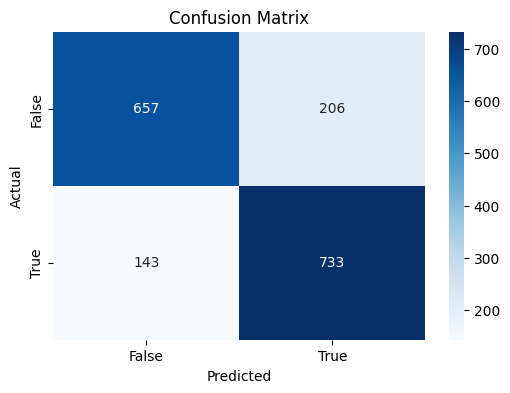

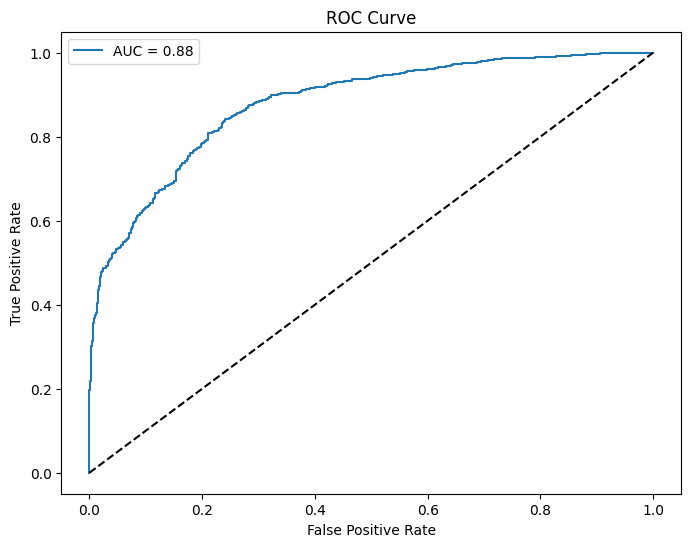


Feature Coefficients:
                      Feature  Coefficient
22                CabinDeck_G     0.979561
8                         VIP     0.647961
24          CabinDeck_missing     0.392683
15    Destination_TRAPPIST-1e     0.377577
14  Destination_PSO J318.5-22     0.279199
10           HomePlanet_Earth     0.271752
6                    CabinNum     0.071967
9                 IsStarboard     0.068278
16                CabinDeck_A     0.059154
2                   FoodCourt     0.044088
21                CabinDeck_F     0.020059
3                ShoppingMall     0.011649
18                CabinDeck_C     0.008138
20                CabinDeck_E    -0.003786
11          HomePlanet_Europa    -0.022088
12            HomePlanet_Mars    -0.028443
23                CabinDeck_T    -0.037693
5                      VRDeck    -0.075999
13    Destination_55 Cancri e    -0.079039
1                 RoomService    -0.094696
4                         Spa    -0.111550
0                         Age  

In [31]:
full_pipeline, cont_cols, cat_cols, bin_cols = build_pipeline(X_train)


def objective(trial):
    C = trial.suggest_float("classifier__C", 0.01, 100, log=True)
    penalty = trial.suggest_categorical("classifier__penalty", ["l1", "l2"])
    solver = "liblinear"

    clf = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight="balanced",
        max_iter=1000,
        random_state=42,
    )
    pipeline = Pipeline(
        [
            ("preprocessor", full_pipeline),
            ("classifier", clf),
        ]
    )
    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1,
    ).mean()
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params_lr = {
    "C": study.best_params["classifier__C"],
    "penalty": study.best_params["classifier__penalty"],
    "solver": "liblinear",
    "class_weight": "balanced",
    "max_iter": 1000,
    "random_state": 42,
}

print("Best parameters:", best_params_lr)
print(f"Best CV F1 score: {study.best_value:.3f}")

best_clf = LogisticRegression(**best_params_lr)

final_pipeline = Pipeline(
    [
        ("preprocessor", full_pipeline),
        ("classifier", best_clf),
    ]
)
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

evaluate_model_performance(y_test, y_pred, y_proba)

feature_names = get_feature_names(
    final_pipeline.named_steps["preprocessor"], cont_cols, cat_cols, bin_cols
)
coefficients = final_pipeline.named_steps["classifier"].coef_[0]
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
print("\nFeature Coefficients:")
print(coef_df.sort_values("Coefficient", ascending=False))

## Decision Tree Model
The model here has an accuracy of **0.78**.

[I 2025-06-30 15:14:06,501] A new study created in memory with name: no-name-0c273507-2356-4a35-8a9b-079fc2ba808c
[I 2025-06-30 15:14:09,340] Trial 0 finished with value: 0.7712425139599353 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 16, 'class_weight': None}. Best is trial 0 with value: 0.7712425139599353.
[I 2025-06-30 15:14:12,967] Trial 1 finished with value: 0.7510058605281744 and parameters: {'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 5, 'class_weight': None}. Best is trial 0 with value: 0.7712425139599353.
[I 2025-06-30 15:14:15,528] Trial 2 finished with value: 0.7634545850265548 and parameters: {'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7712425139599353.
[I 2025-06-30 15:14:18,583] Trial 3 finished with value: 0.7918505289451756 and parameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'class_weight': None}. Best is trial 3 


Best parameters found:
{'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 15, 'class_weight': 'balanced'}

Best cross-validation F1 score: 0.793


C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.70      0.76       863
        True       0.74      0.86      0.80       876

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.79      0.78      0.78      1739


Test AUC: 0.857
Test Accuracy: 0.781


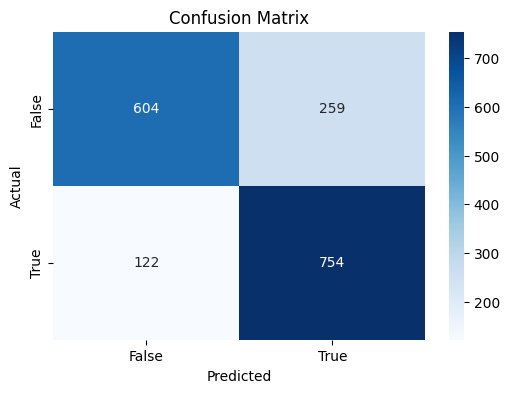

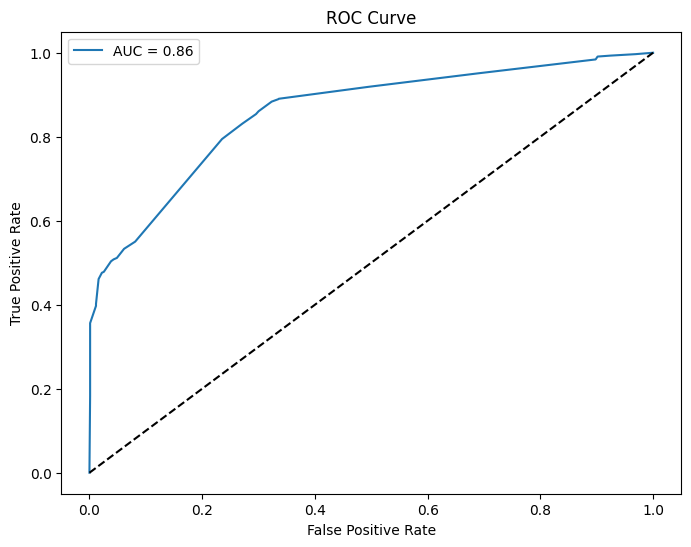


Feature Importances:
                      Feature  Importance
22                CabinDeck_G    0.504732
4                         Spa    0.109804
5                      VRDeck    0.096527
1                 RoomService    0.068292
7                   CryoSleep    0.066574
2                   FoodCourt    0.048176
8                         VIP    0.040015
24          CabinDeck_missing    0.016084
17                CabinDeck_B    0.016022
6                    CabinNum    0.015584
18                CabinDeck_C    0.005270
3                ShoppingMall    0.004902
12            HomePlanet_Mars    0.003270
19                CabinDeck_D    0.002482
0                         Age    0.002269
10           HomePlanet_Earth    0.000000
9                 IsStarboard    0.000000
16                CabinDeck_A    0.000000
15    Destination_TRAPPIST-1e    0.000000
14  Destination_PSO J318.5-22    0.000000
13    Destination_55 Cancri e    0.000000
11          HomePlanet_Europa    0.000000
20          

In [32]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=42,
    )
    pipeline = Pipeline(
        [
            ("preprocessor", full_pipeline),
            ("classifier", clf),
        ]
    )
    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1,
    ).mean()
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params_dt = {
    "max_depth": study.best_params["max_depth"],
    "min_samples_split": study.best_params["min_samples_split"],
    "min_samples_leaf": study.best_params["min_samples_leaf"],
    "class_weight": study.best_params["class_weight"],
}

print("\nBest parameters found:")
print(best_params_dt)
print(f"\nBest cross-validation F1 score: {study.best_value:.3f}")

best_clf = DecisionTreeClassifier(**best_params_dt, random_state=42)
best_model = Pipeline(
    [
        ("preprocessor", full_pipeline),
        ("classifier", best_clf),
    ]
)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

feature_names = get_feature_names(
    best_model.named_steps["preprocessor"], cont_cols, cat_cols, bin_cols
)

importances = best_model.named_steps["classifier"].feature_importances_

importances_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importances_df)

## Support Vector Machine
The model here has an accuracy of **0.80**.

[I 2025-06-30 15:15:54,166] A new study created in memory with name: no-name-b53cd306-1777-44b9-be67-90b9896eb715
[I 2025-06-30 15:16:07,036] Trial 0 finished with value: 0.7812953468489154 and parameters: {'kernel': 'rbf', 'C': 0.9436719048146478, 'class_weight': None, 'gamma': 'auto'}. Best is trial 0 with value: 0.7812953468489154.
[I 2025-06-30 15:16:16,967] Trial 1 finished with value: 0.7927973875390806 and parameters: {'kernel': 'rbf', 'C': 0.15795919098499966, 'class_weight': 'balanced', 'gamma': 'scale'}. Best is trial 1 with value: 0.7927973875390806.
[I 2025-06-30 15:16:46,092] Trial 2 finished with value: 0.7780269056933236 and parameters: {'kernel': 'linear', 'C': 0.6197432407901406, 'class_weight': None}. Best is trial 1 with value: 0.7927973875390806.
[I 2025-06-30 15:16:56,808] Trial 3 finished with value: 0.7912064066724116 and parameters: {'kernel': 'rbf', 'C': 0.11368435864175808, 'class_weight': 'balanced', 'gamma': 'scale'}. Best is trial 1 with value: 0.7927973875


Best parameters:
{'kernel': 'rbf', 'C': 1.1644387821464983, 'class_weight': None, 'gamma': 'scale'}


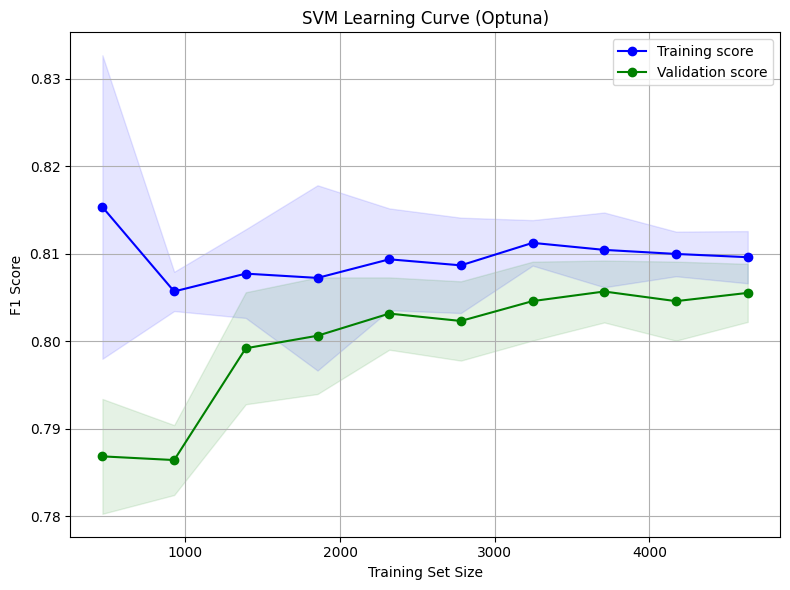

C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.74      0.79       863
        True       0.77      0.86      0.81       876

    accuracy                           0.80      1739
   macro avg       0.81      0.80      0.80      1739
weighted avg       0.81      0.80      0.80      1739


Test AUC: 0.867
Test Accuracy: 0.801


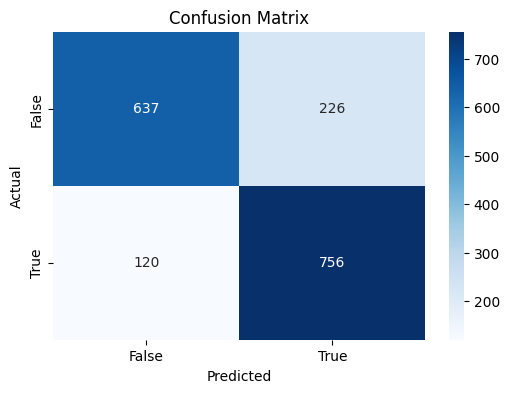

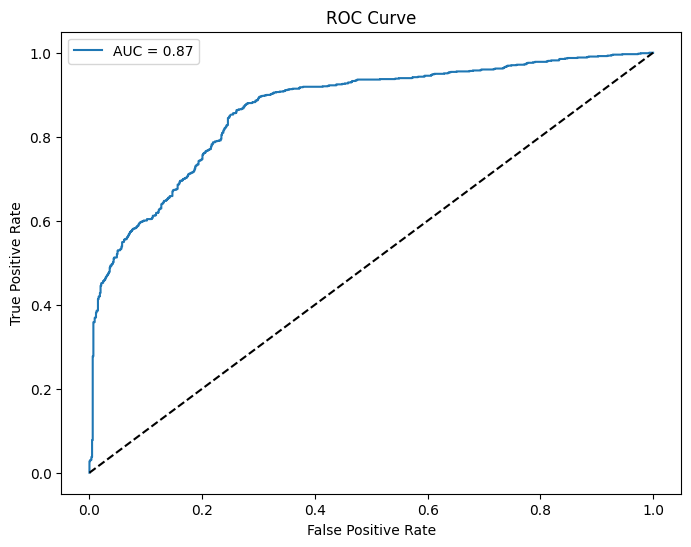


Feature coefficients only available for linear kernel
Selected kernel: rbf


In [33]:
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    C = trial.suggest_float("C", 0.1, 10.0, log=True)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    gamma = "scale"
    if kernel == "rbf":
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])

    clf = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        class_weight=class_weight,
        probability=True,
        random_state=42,
    )

    pipeline = Pipeline([("preprocessor", full_pipeline), ("classifier", clf)])

    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=StratifiedKFold(n_splits=3),
        n_jobs=-1,
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=900)

best_params_svc = {
    "kernel": study.best_params["kernel"],
    "C": study.best_params["C"],
    "class_weight": study.best_params["class_weight"],
    "gamma": study.best_params.get("gamma", "scale"),
}

print("\nBest parameters:")
print(best_params_svc)

final_clf = SVC(
    kernel=best_params_svc["kernel"],
    C=best_params_svc["C"],
    gamma=best_params_svc["gamma"],
    class_weight=best_params_svc["class_weight"],
    probability=True,
    random_state=42,
)

best_model = Pipeline(
    [
        ("preprocessor", full_pipeline),
        ("classifier", final_clf),
    ]
)

best_model.fit(X_train, y_train)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=3),
    title="SVM Learning Curve (Optuna)",
)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

if best_params_svc["kernel"] == "linear":
    feature_names = get_feature_names(
        best_model.named_steps["preprocessor"], cont_cols, cat_cols, bin_cols
    )
    coefficients = best_model.named_steps["classifier"].coef_[0]

    coef_df = pd.DataFrame(
        {"Feature": feature_names, "Coefficient": coefficients}
    ).sort_values("Coefficient", ascending=False)

    print("\nFeature Coefficients:")
    print(coef_df)
else:
    print("\nFeature coefficients only available for linear kernel")
    print("Selected kernel:", best_params_svc["kernel"])

## Naive Bayes Model
The model here has an accuracy of **0.76**.

[I 2025-06-30 15:28:47,362] A new study created in memory with name: no-name-b0f2d5d6-c8b5-44ea-8fdc-826fd95d12d7
[I 2025-06-30 15:28:49,668] Trial 0 finished with value: 0.7708969568932796 and parameters: {'var_smoothing': 1.60327494081103e-08}. Best is trial 0 with value: 0.7708969568932796.
[I 2025-06-30 15:28:51,757] Trial 1 finished with value: 0.7804728117482875 and parameters: {'var_smoothing': 3.2050169401740613e-06}. Best is trial 1 with value: 0.7804728117482875.
[I 2025-06-30 15:28:53,757] Trial 2 finished with value: 0.7779774491124043 and parameters: {'var_smoothing': 7.2334952416445e-07}. Best is trial 1 with value: 0.7804728117482875.
[I 2025-06-30 15:28:55,692] Trial 3 finished with value: 0.7813735815844501 and parameters: {'var_smoothing': 0.00015133365767445412}. Best is trial 3 with value: 0.7813735815844501.
[I 2025-06-30 15:28:57,700] Trial 4 finished with value: 0.7685011815208427 and parameters: {'var_smoothing': 1.9856713865624177e-09}. Best is trial 3 with val


Best parameters found:
{'var_smoothing': 2.0231831418195623e-05}

Best cross-validation F1 score: 0.784


C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.64      0.73       863
        True       0.71      0.88      0.79       876

    accuracy                           0.76      1739
   macro avg       0.78      0.76      0.76      1739
weighted avg       0.78      0.76      0.76      1739


Test AUC: 0.857
Test Accuracy: 0.762


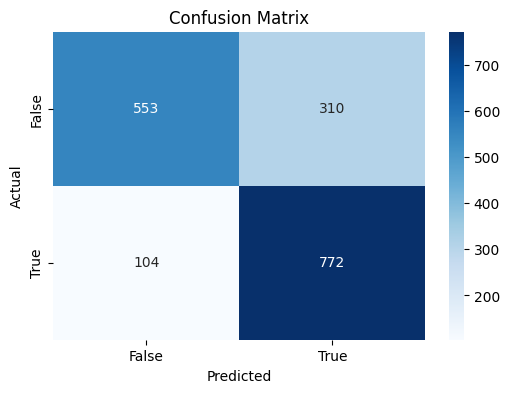

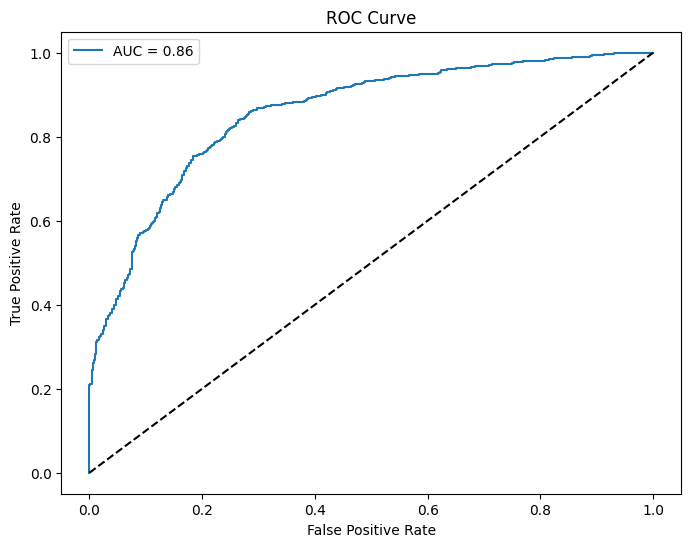

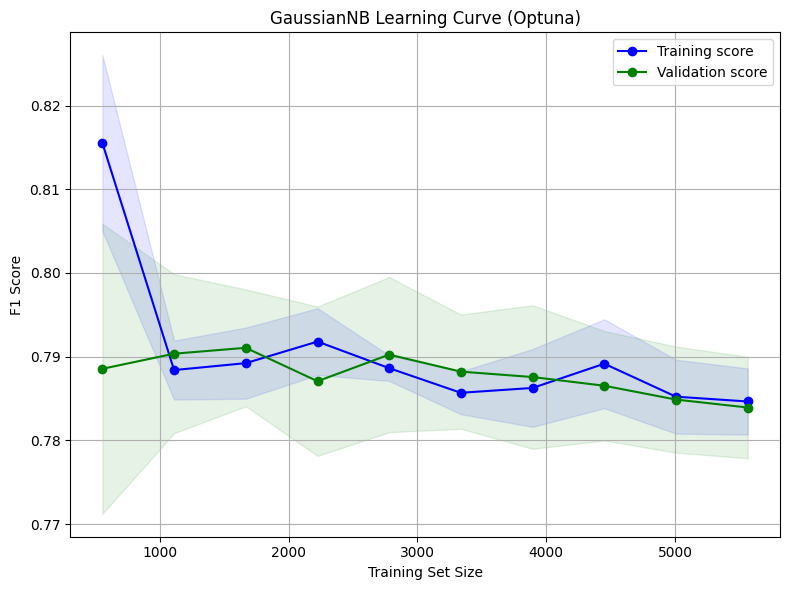


Number of features: 25
Means length: 25
Variances length: 25

Feature Means:
                      Feature      Mean
5                      VRDeck  9.902711
4                         Spa  8.265590
1                 RoomService  6.184236
3                ShoppingMall  5.808305
2                   FoodCourt  5.021156
12            HomePlanet_Mars  0.738992
7                   CryoSleep  0.636732
24          CabinDeck_missing  0.440614
18                CabinDeck_C  0.365585
19                CabinDeck_D  0.287370
6                    CabinNum  0.239005
9                 IsStarboard  0.197567
10           HomePlanet_Earth  0.166860
8                         VIP  0.165701
0                         Age  0.151661
17                CabinDeck_B  0.128331
22                CabinDeck_G  0.128042
11          HomePlanet_Europa  0.094148
16                CabinDeck_A  0.061703
15    Destination_TRAPPIST-1e  0.055910
14  Destination_PSO J318.5-22  0.048088
23                CabinDeck_T  0.028969
13

In [34]:
def objective(trial):
    var_smoothing = trial.suggest_float("var_smoothing", 1e-9, 1e0, log=True)
    clf = GaussianNB(var_smoothing=var_smoothing)
    pipeline = Pipeline([("preprocessor", full_pipeline), ("classifier", clf)])
    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1,
    ).mean()
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params_gnb = {"var_smoothing": study.best_params["var_smoothing"]}

print("\nBest parameters found:")
print(best_params_gnb)
print(f"\nBest cross-validation F1 score: {study.best_value:.3f}")

best_clf = GaussianNB(var_smoothing=best_params_gnb["var_smoothing"])
best_model = Pipeline([("preprocessor", full_pipeline), ("classifier", best_clf)])
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="GaussianNB Learning Curve (Optuna)",
)

if hasattr(best_model.named_steps["classifier"], "theta_"):
    feature_names = get_feature_names(
        best_model.named_steps["preprocessor"], cont_cols, cat_cols, bin_cols
    )
    means = best_model.named_steps["classifier"].theta_[0]
    variances = best_model.named_steps["classifier"].var_[0]
    print(f"\nNumber of features: {len(feature_names)}")
    print(f"Means length: {len(means)}")
    print(f"Variances length: {len(variances)}")
    means_df = pd.DataFrame({"Feature": feature_names, "Mean": means}).sort_values(
        "Mean", ascending=False
    )
    variances_df = pd.DataFrame(
        {"Feature": feature_names, "Variance": variances}
    ).sort_values("Variance", ascending=False)
    print("\nFeature Means:")
    print(means_df)
    print("\nFeature Variances:")
    print(variances_df)
else:
    print("\nFeature statistics not available for this model")

# Ensemble Models

## Random Forest
The model here has an accuracy of **0.80**.

[I 2025-06-30 15:30:06,595] A new study created in memory with name: no-name-f9ec7a26-6382-4dc6-b46b-ed37e8f1d718
[I 2025-06-30 15:30:11,626] Trial 0 finished with value: 0.7987942378793798 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'class_weight': None, 'max_features': 'log2'}. Best is trial 0 with value: 0.7987942378793798.
[I 2025-06-30 15:30:15,656] Trial 1 finished with value: 0.746296533463026 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 10, 'class_weight': 'balanced', 'max_features': 'log2'}. Best is trial 0 with value: 0.7987942378793798.
[I 2025-06-30 15:30:24,834] Trial 2 finished with value: 0.7920089720798873 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'class_weight': 'balanced', 'max_features': None}. Best is trial 0 with value: 0.7987942378793798.
[I 2025-06-30 15:30:33,630] Trial 3 finished with value: 0.7876151778855951 and parameters: {'n_estimators': 200, 'max_depth'


Best parameters found:
{'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'class_weight': None, 'max_features': 'sqrt'}

Best cross-validation F1 score: 0.803


C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.80      0.80       863
        True       0.80      0.80      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


Test AUC: 0.899
Test Accuracy: 0.802


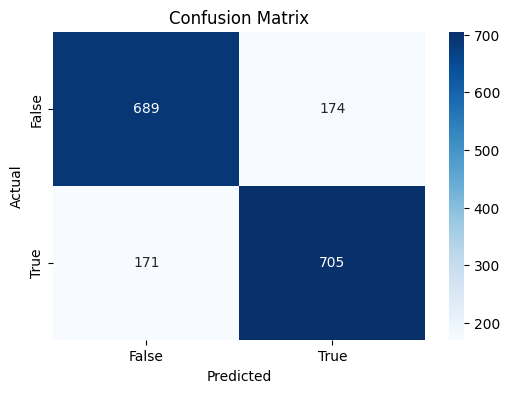

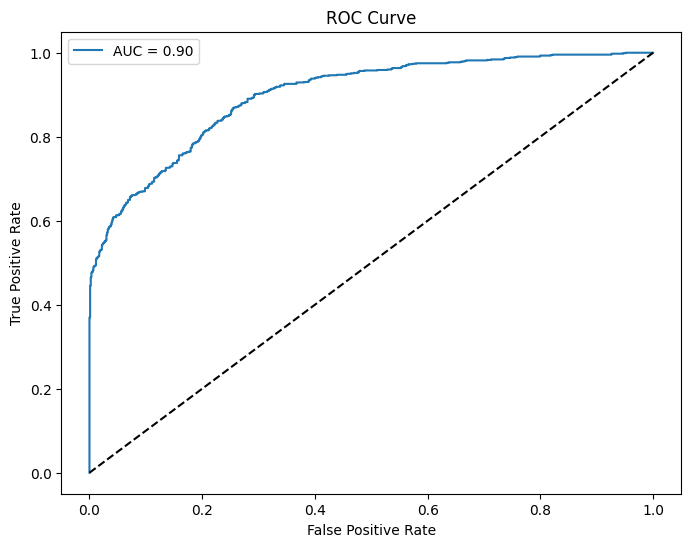

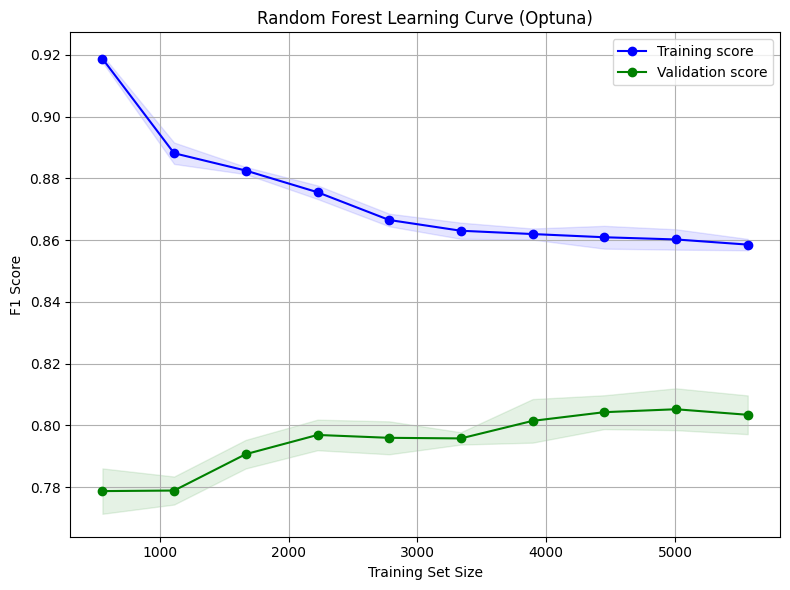


Feature Importances:
                      Feature  Importance
4                         Spa    0.162780
22                CabinDeck_G    0.142379
1                 RoomService    0.129294
5                      VRDeck    0.115778
2                   FoodCourt    0.094864
3                ShoppingMall    0.076364
6                    CabinNum    0.054742
0                         Age    0.048767
7                   CryoSleep    0.033740
8                         VIP    0.030165
24          CabinDeck_missing    0.016106
17                CabinDeck_B    0.015969
9                 IsStarboard    0.014557
19                CabinDeck_D    0.013444
18                CabinDeck_C    0.012821
15    Destination_TRAPPIST-1e    0.007187
14  Destination_PSO J318.5-22    0.007102
12            HomePlanet_Mars    0.006168
10           HomePlanet_Earth    0.005912
11          HomePlanet_Europa    0.003682
16                CabinDeck_A    0.002322
23                CabinDeck_T    0.002070
13    Destin

In [35]:
def objective(trial):
    n_estimators = trial.suggest_categorical("n_estimators", [50, 100, 200])
    max_depth = trial.suggest_categorical("max_depth", [None, 5, 10, 20])
    min_samples_split = trial.suggest_categorical("min_samples_split", [2, 5, 10])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        class_weight=class_weight,
        max_features=max_features,
        random_state=42,
        n_jobs=-1,
    )
    pipeline = Pipeline([("preprocessor", full_pipeline), ("classifier", clf)])
    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1,
    ).mean()
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params_rf = study.best_params

print("\nBest parameters found:")
print(best_params_rf)
print(f"\nBest cross-validation F1 score: {study.best_value:.3f}")

best_clf = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
best_model = Pipeline([("preprocessor", full_pipeline), ("classifier", best_clf)])
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="Random Forest Learning Curve (Optuna)",
)

feature_names = get_feature_names(
    best_model.named_steps["preprocessor"], cont_cols, cat_cols, bin_cols
)

importances = best_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)

## XGBoost
The model here has an accuracy of **0.80**.

[I 2025-06-30 15:38:46,558] A new study created in memory with name: no-name-1f5c6a45-c1ce-4ef8-9cdf-cccbd21cd80d
[I 2025-06-30 15:38:49,579] Trial 0 finished with value: 0.8132957783632924 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.8132957783632924.
[I 2025-06-30 15:38:52,218] Trial 1 finished with value: 0.7990844691767487 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}. Best is trial 0 with value: 0.8132957783632924.
[I 2025-06-30 15:38:55,476] Trial 2 finished with value: 0.7970573769293997 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.6}. Best is trial 0 with value: 0.8132957783632924.
[I 2025-06-30 15:38:57,587] Trial 3 finished with value: 0.8095264784039099 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 's


Best parameters found:
{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}

Best cross-validation F1 score: 0.813


C:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:42:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.77      0.79       863
        True       0.79      0.82      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


Test AUC: 0.904
Test Accuracy: 0.799


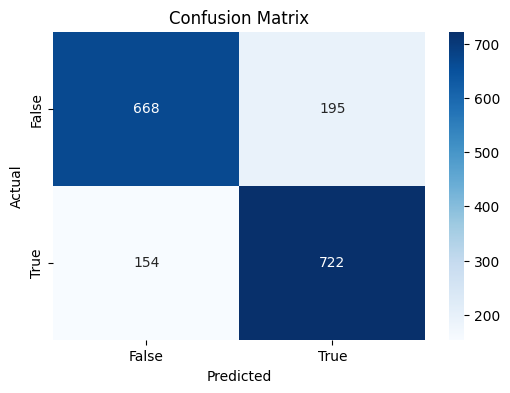

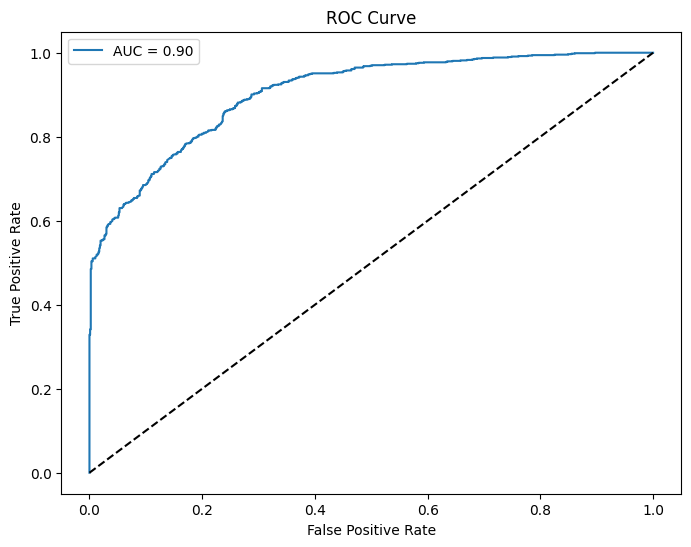

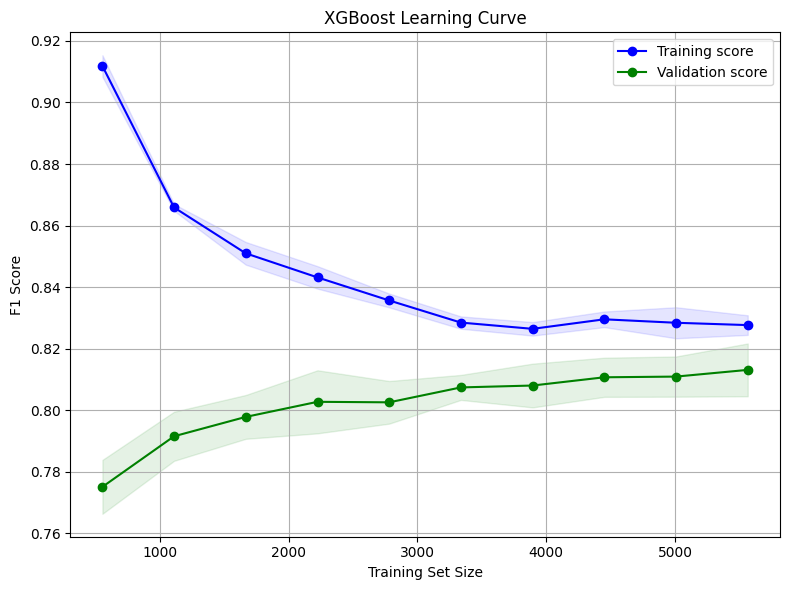


Feature Importances:
                      Feature  Importance
22                CabinDeck_G    0.528941
7                   CryoSleep    0.065410
19                CabinDeck_D    0.044926
8                         VIP    0.044689
1                 RoomService    0.040984
4                         Spa    0.035310
5                      VRDeck    0.027978
17                CabinDeck_B    0.026872
2                   FoodCourt    0.024851
24          CabinDeck_missing    0.024157
0                         Age    0.016648
6                    CabinNum    0.016470
3                ShoppingMall    0.015007
15    Destination_TRAPPIST-1e    0.014551
10           HomePlanet_Earth    0.014230
9                 IsStarboard    0.011692
14  Destination_PSO J318.5-22    0.010285
18                CabinDeck_C    0.008894
12            HomePlanet_Mars    0.008737
16                CabinDeck_A    0.008549
13    Destination_55 Cancri e    0.008305
23                CabinDeck_T    0.002513
11          

In [36]:
def objective(trial):
    n_estimators = trial.suggest_categorical("n_estimators", [50, 100, 200])
    max_depth = trial.suggest_categorical("max_depth", [3, 5, 10, 20])
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.1, 0.2])
    subsample = trial.suggest_categorical("subsample", [0.6, 0.8, 1.0])
    colsample_bytree = trial.suggest_categorical("colsample_bytree", [0.6, 0.8, 1.0])
    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    )
    pipeline = Pipeline([("preprocessor", full_pipeline), ("classifier", clf)])
    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1,
    ).mean()
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params_xgb = study.best_params

print("\nBest parameters found:")
print(best_params_xgb)
print(f"\nBest cross-validation F1 score: {study.best_value:.3f}")

best_clf = XGBClassifier(
    **best_params_xgb,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)
best_model = Pipeline([("preprocessor", full_pipeline), ("classifier", best_clf)])
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="XGBoost Learning Curve",
)

feature_names = get_feature_names(
    best_model.named_steps["preprocessor"], cont_cols, cat_cols, bin_cols
)
importances = best_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)

## LightGBM
The model here has an accuracy of **0.81**.

[I 2025-06-30 15:42:41,089] A new study created in memory with name: no-name-7abc5a55-e06a-4500-b135-ce87d6e477ce
[I 2025-06-30 15:42:48,496] Trial 0 finished with value: 0.7937677968894714 and parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7937677968894714.
[I 2025-06-30 15:42:51,345] Trial 1 finished with value: 0.8013837716184675 and parameters: {'n_estimators': 50, 'max_depth': -1, 'learning_rate': 0.2, 'num_leaves': 31, 'subsample': 1.0, 'colsample_bytree': 0.8, 'class_weight': None}. Best is trial 1 with value: 0.8013837716184675.
[I 2025-06-30 15:42:54,385] Trial 2 finished with value: 0.8026792341817129 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 50, 'subsample': 0.8, 'colsample_bytree': 0.6, 'class_weight': None}. Best is trial 2 with value: 0.8026792341817129.
[I 2025-06-30 15:43:00,24


Best parameters found:
{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'num_leaves': 31, 'subsample': 1.0, 'colsample_bytree': 1.0, 'class_weight': 'balanced'}

Best cross-validation F1 score: 0.812
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.80      0.81       863
        True       0.81      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739


Test AUC: 0.908
Test Accuracy: 0.811


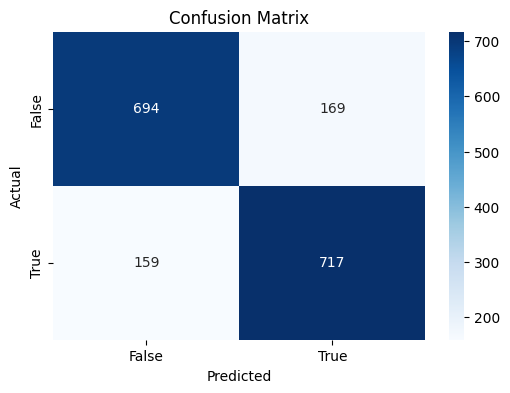

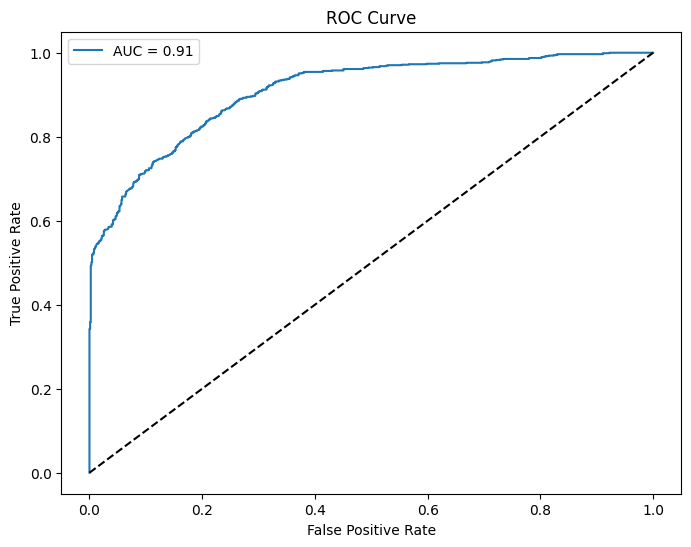

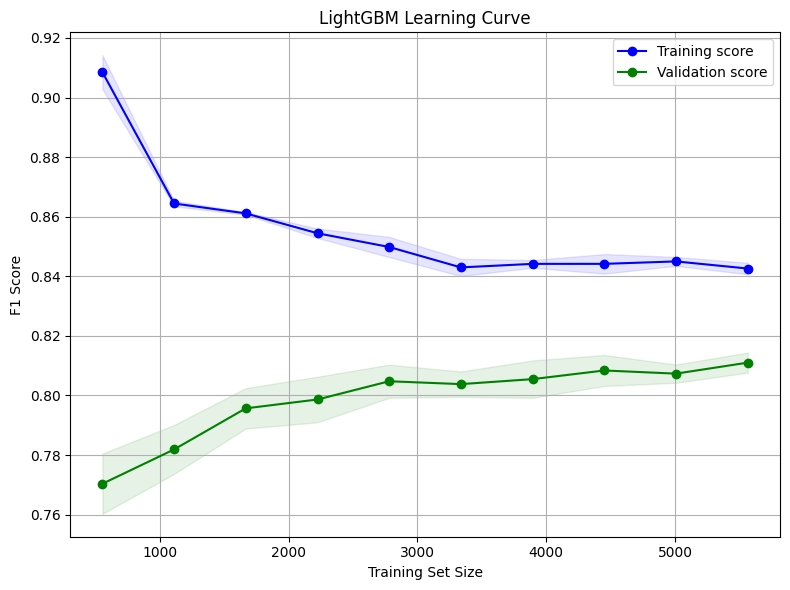


Feature Importances:
                      Feature  Importance
6                    CabinNum         353
2                   FoodCourt         289
5                      VRDeck         284
0                         Age         282
4                         Spa         270
24          CabinDeck_missing         180
1                 RoomService         160
3                ShoppingMall         159
7                   CryoSleep          63
17                CabinDeck_B          62
8                         VIP          58
22                CabinDeck_G          53
12            HomePlanet_Mars          49
15    Destination_TRAPPIST-1e          44
18                CabinDeck_C          42
19                CabinDeck_D          34
13    Destination_55 Cancri e          29
9                 IsStarboard          20
10           HomePlanet_Earth          18
14  Destination_PSO J318.5-22          12
21                CabinDeck_F          11
23                CabinDeck_T           5
11          

In [37]:
def objective(trial):
    n_estimators = trial.suggest_categorical("n_estimators", [50, 100, 200])
    max_depth = trial.suggest_categorical("max_depth", [-1, 5, 10, 20])
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.05, 0.1, 0.2])
    num_leaves = trial.suggest_categorical("num_leaves", [31, 50, 100])
    subsample = trial.suggest_categorical("subsample", [0.6, 0.8, 1.0])
    colsample_bytree = trial.suggest_categorical("colsample_bytree", [0.6, 0.8, 1.0])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    clf = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1,
    )
    pipeline = Pipeline([("preprocessor", full_pipeline), ("classifier", clf)])
    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring="f1",
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1,
    ).mean()
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params_lgb = study.best_params

print("\nBest parameters found:")
print(best_params_lgb)
print(f"\nBest cross-validation F1 score: {study.best_value:.3f}")

best_clf = lgb.LGBMClassifier(**best_params_lgb, random_state=42, n_jobs=-1)
best_model = Pipeline([("preprocessor", full_pipeline), ("classifier", best_clf)])
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

evaluate_model_performance(
    y_test, y_pred, y_proba, class_labels=["No Stroke", "Stroke"]
)

plot_learning_curve(
    best_model,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="LightGBM Learning Curve",
)

feature_names = get_feature_names(
    best_model.named_steps["preprocessor"], cont_cols, cat_cols, bin_cols
)

importances = best_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)

## Voting Model

Training voting classifier...


C:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:46:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.76      0.79       863
        True       0.78      0.84      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


Test AUC: 0.901
Test Accuracy: 0.801


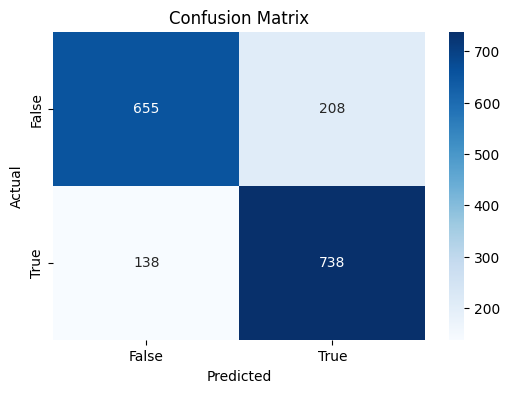

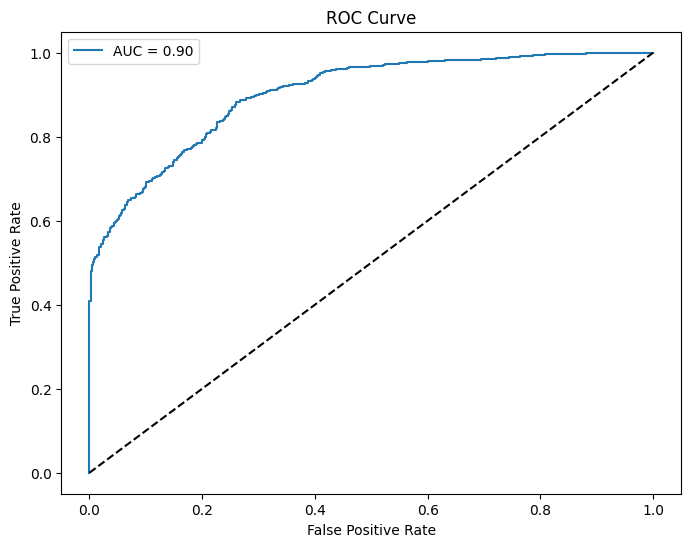

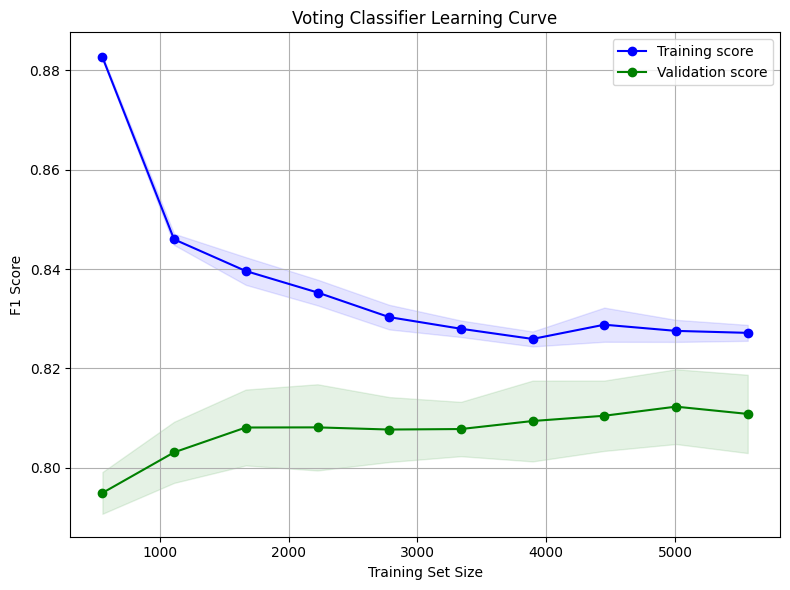

In [38]:
logistic = LogisticRegression(
    C=best_params_lr["C"],
    penalty=best_params_lr["penalty"],
    solver="liblinear",
    random_state=42,
    max_iter=1000,
    class_weight="balanced",
)

svm = SVC(
    C=best_params_svc["C"],
    kernel=best_params_svc["kernel"],
    gamma=best_params_svc.get("gamma", "scale"),
    class_weight=best_params_svc["class_weight"],
    probability=True,
    random_state=42,
)

random_forest = RandomForestClassifier(
    n_estimators=best_params_rf["n_estimators"],
    max_depth=best_params_rf["max_depth"],
    min_samples_split=best_params_rf["min_samples_split"],
    max_features=best_params_rf["max_features"],
    class_weight=best_params_rf["class_weight"],
    random_state=42,
)

xgb = XGBClassifier(
    n_estimators=best_params_xgb["n_estimators"],
    max_depth=best_params_xgb["max_depth"],
    learning_rate=best_params_xgb["learning_rate"],
    subsample=best_params_xgb["subsample"],
    colsample_bytree=best_params_xgb["colsample_bytree"],
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

lgbm = lgb.LGBMClassifier(
    n_estimators=best_params_lgb["n_estimators"],
    max_depth=best_params_lgb["max_depth"],
    learning_rate=best_params_lgb["learning_rate"],
    num_leaves=best_params_lgb["num_leaves"],
    subsample=best_params_lgb["subsample"],
    colsample_bytree=best_params_lgb["colsample_bytree"],
    class_weight=best_params_lgb["class_weight"],
    random_state=42,
    n_jobs=-1,
)


voting_clf = VotingClassifier(
    estimators=[
        ("lr", logistic),
        ("svc", svm),
        ("rf", random_forest),
        ("xgb", xgb),
        ("lgbm", lgbm),
    ],
    voting="soft",
    weights=None,
)

pipeline = Pipeline([("preprocessor", full_pipeline), ("classifier", voting_clf)])

print("Training voting classifier...")
pipeline.fit(X_train, y_train)

print("\nEvaluating on test set...")
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

evaluate_model_performance(y_test, y_pred, y_proba)

plot_learning_curve(
    pipeline,
    X_train,
    y_train,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5),
    title="Voting Classifier Learning Curve",
)

### Summary of the Best
Most models seem to be quite closely related. As the only thing that we care about in this analysis, this is what I focus on here:

1. LightGBM - Accuracy of **0.81**.
2. XGBoost, SVM, Random Forest, Logistic Regression, Voting Model - Accuracy of **0.80**.
3. Decision Tree - Accuracy **0.78**.
4. Naive Bayes - Accuracy of **0.76**.


# Deploying the Model on the Kaggle Test Set

In [39]:
test_data = pd.read_csv("test.csv", index_col=0)

In [40]:
best_clf = lgb.LGBMClassifier(**best_params_lgb, random_state=42, n_jobs=-1)
best_model = Pipeline([("preprocessor", full_pipeline), ("classifier", best_clf)])
best_model.fit(X_train, y_train)

test_preds = best_model.predict(test_data)

submission = pd.DataFrame({"PassengerId": test_data.index, "Transported": test_preds})

submission.to_csv("submission.csv", index=False)

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\david\anaconda3\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\david\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Final Score
After uploading to Kaggle, I see that the final score of my solution is **0.80313**. This means that 80.313% of all predictions were correct.

# Conclusion

In this analysis, I performed a variety of data cleaning and feature engineering to run both an inferential and an ML model to ultimately predict whether people were transported to this otherwordly dimension. I ran a variety of different ML models, namely logistic regression, decision tree, naive bayes, support vector classifier, random forest, XGBoost, LightGBM, and a voting model consisting of the highest performing models.
Interestingly, all ML models seemed to have strikingly similar results, which is likely due Kaggle formatting the data such that performance is less dependent on the model run, but rather a variety of tricks to introduce noise which require more data cleaning.

Ultimately, my results here resulted in a score of **0.80313**, which is better than the minimum of 0.79 required by the assignment.

Aspects to potentially improve:
- **Use models more capable of observing hidden relationships** between factors, such as neural networks. Here I stuck to models which I am more familiar with, as I did not want to use models I have not studied more closely
- **Further data cleaning / engineering** to explore this hidden patterns more. For example, I only extracted a single column of insightful data from the names of passenger (i.e., the length of their name). I considered number of spaces or hyphens, but I figured these cases to be so common that they would correlate with other features (i.e., spaces), or so rare that they would not contribute anything (i.e., hyphens)
- **More data**. Given the very low amount of positive cases, this makes it hard to reliably predict this case. Furthermore, with many of the features only occupying a binary scale, this makes tools like SMOTE unreliable, and any oversampling technique to more so increase the likelihood of overfitting. As such, the access to a higher, as well as deeper features, would likely improve this model.
- **More investigation into false predictions**. In a real scenario, it would have also been beneficial to look into the false predictions of the different models to try to get an understanding of which data cases the model typically misclassifies. This could have both given insights into how to better structure/clean the data, as well as practical advice for stakeholders on when the model should not be used.
- **Feature Selection**. I did not use any feature selection, but doing so would likely improve efficiency, as well as potentially performance.
- **More Code Offloading into seperate files**
- **Experiment Tracking**. It would be prudent and clean to consolidate the results into one coherent table for later summarization. This would add clarity and conciseness.